In [1]:
import logging
import multiprocessing
import os
import random
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from facenet_pytorch import MTCNN
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

from deepfake_dataset import DeepfakeDataset, collate_fn
from worker import worker_init_fn

In [2]:
BASE_VIDEO_PATH = "./dataset"
METADATA_PATH = "./dataset/celeb_df_metadata.csv"

# Data Preprocessing Pipeline

Imports and Logging Setup: This section imports necessary libraries (e.g., cv2 for video handling, torch for tensors, MTCNN for face detection) and configures logging. Logging is crucial for robustness, as the PDF highlights potential issues like corrupted videos or face detection failures; it allows tracking warnings/errors without crashing the pipeline.

Class Initialization (__init__): Initializes the dataset with metadata, transformations, frame count, and image size. It sets up MTCNN for face detection on GPU if available, ensuring efficiency for large datasets like Celeb-DF-v2 with varying video qualities.

Length Method (__len__): Returns the number of videos in the metadata, enabling PyTorch's DataLoader to iterate correctly. This is standard but essential for handling the imbalanced dataset size (890 real vs. 5639 fake).

Face Extraction Method (extract_faces_from_video): Handles video reading with error checks (e.g., file existence, opening failures) to prevent crashes on problematic files. It uses adaptive sampling (random for short videos, uniform for longer ones) to capture temporal information without bias, extracts faces via MTCNN, and logs failures for debugging.

Item Retrieval Method (__getitem__): Fetches a video's data by index, assigns binary labels (0 for real, 1 for fake), extracts faces, and handles shortages with noise-added repetitions to avoid overfitting on duplicates. It applies transformations and stacks frames into a tensor, preparing consistent inputs despite dataset variability.

In [3]:
# Setup logging for robustness
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
# Reconfigure the root logger to ensure output appears in the notebook
logger = logging.getLogger()
logger.handlers = []  # Clear any existing handlers
handler = logging.StreamHandler(
    sys.stdout
)  # Create a new handler to stream to the console
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

# Data Augmentation and Transforms

Training Transforms (train_transforms): Composes a sequence of augmentations starting with PIL conversion for compatibility, resizing to 224x224 (standard for backbones like EfficientNet), and random flips/rotations to simulate pose variations. Color jitter and affine shear address lighting/quality inconsistencies, enhancing robustness without masking deepfake artifacts; normalization uses ImageNet stats for transfer learning.

Validation Transforms (val_transforms): A minimal composition for evaluation, including PIL conversion, resizing, tensor conversion, and normalization. This ensures consistent inputs without random augmentations, allowing fair assessment of model generalization on the imbalanced validation set.

In [4]:
# Define enhanced data augmentation for training robustness, considering dataset variability
train_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomAffine(degrees=0, shear=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Model Architecture Implementation

Class Initialization (__init__): Sets up the model with frame count (20 for better temporal coverage), selects a pretrained CNN backbone (e.g., EfficientNet-B4 for efficiency on facial details), and defines bidirectional LSTMs for temporal analysis, attention layers for focusing on key frames, and a classifier with batch norm/dropout for stability on imbalanced data.

Forward Pass (forward): Reshapes input for batch CNN processing, extracts features with mixed precision for speed, reshapes for LSTM, applies bidirectional temporal modeling to detect inconsistencies, weights frames via attention (useful for variable-length videos), and classifies via dense layers, outputting a sigmoid probability for real/fake.

In [5]:
import torchvision.models as models
from torch.cuda.amp import autocast
from torch.nn import functional as F


class DeepfakeDetector(nn.Module):
    def __init__(self, num_frames=20, backbone="efficientnet_b4", dropout_rate=0.6):
        super(DeepfakeDetector, self).__init__()
        self.num_frames = num_frames

        # CNN Backbone for feature extraction
        if backbone == "efficientnet_b4":
            weights = models.EfficientNet_B4_Weights.IMAGENET1K_V1
            # self.backbone = models.efficientnet_b4(pretrained=True)
            self.backbone = models.efficientnet_b4(weights=weights)
            self.backbone.classifier = nn.Identity()  # Remove final classifier
            feature_dim = 1792
        elif backbone == "resnet50":
            weights = models.ResNet50_Weights.IMAGENET1K_V1
            self.backbone = models.resnet50(weights=weights)
            # self.backbone = models.resnet50(pretrained=True)
            self.backbone.fc = nn.Identity()
            feature_dim = 2048

        # Temporal processing layers with bidirectional LSTM for better sequence modeling
        self.lstm = nn.LSTM(
            input_size=feature_dim,
            hidden_size=512,
            num_layers=3,
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=True,
        )

        # Attention mechanism for frame importance weighting
        self.attention = nn.Sequential(
            nn.Linear(1024, 256), nn.ReLU(), nn.Linear(256, 1), nn.Softmax(dim=1)
        )

        # Final classification layers with additional regularization
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),  # Adjusted for bidirectional
            nn.BatchNorm1d(256),  # Added for stability
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, num_frames, C, H, W = x.shape
        x = x.view(batch_size * num_frames, C, H, W)

        # Use torch.amp.autocast for mixed precision
        with torch.amp.autocast(device_type="cuda"):
            features = self.backbone(x)

        features = features.view(batch_size, num_frames, -1)
        lstm_out, _ = self.lstm(features)

        attention_weights = self.attention(lstm_out)

        # The correct approach is to multiply lstm_out by the attention weights
        # and then sum across the time dimension.
        # weighted_features = (lstm_out * attention_weights).sum(dim=1)
        # weighted_features = lstm_out * attention_weights + lstm_out  # Helps with gradient flow.
        # weighted_features = weighted_features.mean(dim=1)  # Reduce over sequence dimension (average pooling)

        # output = self.classifier(weighted_features)
        context_vector = (lstm_out * attention_weights).sum(dim=1)
        output = self.classifier(context_vector)

        return output

# Training Setup and Configuration

Training Setup Function (setup_training): Loads metadata, performs stratified split to preserve imbalance ratios, creates datasets, computes sample weights for oversampling (addressing PDF's 1:6 imbalance), and sets up DataLoaders with a sampler for balanced batching.

Training Function (train_model): Configures device/loss/optimizer with weighted BCE for imbalance, initializes mixed-precision scaler, and runs epochs with training loops (forward pass, backprop with clipping for stability), validation (no-grad inference), metrics calculation, scheduling, and early stopping to save the best model and prevent overfitting.

In [6]:
import matplotlib.pyplot as plt
import torch.amp
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = nn.BCEWithLogitsLoss()(inputs, targets)
        pt = torch.exp(-bce_loss)
        return self.alpha * (1 - pt) ** self.gamma * bce_loss


def setup_training():
    # Load metadata from dataset analysis
    metadata = pd.read_csv(METADATA_PATH)
    
    # metadata['filepath'] = metadata['filepath'].apply(lambda x: os.path.join(BASE_VIDEO_PATH, x))
    # Omit the 'Youtube-real' videos to create a more balanced dataset
    metadata = metadata[metadata['folder'] != 'YouTube-real'].copy()
    # Sample 50% of the dataset for a quicker training run
    metadata = metadata.sample(frac=0.3, random_state=42).reset_index(drop=True)
    
    metadata["filepath"] = metadata["filepath"].apply(
        # lambda x: os.path.join(BASE_VIDEO_PATH, x)
        lambda x: os.path.join(BASE_VIDEO_PATH, x)
    )

    # Train/validation split with stratification
    train_df, val_df = train_test_split(
        metadata, test_size=0.2, stratify=metadata["label"], random_state=42
    )

    # Define a cache directory in a writable location
    face_cache_directory = "/kaggle/working/face_cache"
    # Create datasets
    train_dataset = DeepfakeDataset(train_df, transform=train_transforms)
    val_dataset = DeepfakeDataset(val_df, transform=val_transforms)

    # Compute class weights for oversampling to handle imbalance (real: ~890, fake: ~5639 total)
    class_counts = metadata["label"].value_counts()
    # class_weights = {0: 1.0 / class_counts['real'], 1: 1.0 / class_counts['fake']}
    class_weights = {
        0: class_counts["fake"] / class_counts["real"],
        1: 1.0,
    }  # This oversamples real videos more heavily.

    # sample_weights = [class_weights[0] if label == 'real' else class_weights[1] for label in train_df['label']]
    # sample_weights = [class_weights[label] for label in train_df['label']]
    sample_weights = [
        class_weights[1 if label == "fake" else 0] for label in train_df["label"]
    ]

    sampler = WeightedRandomSampler(
        sample_weights, len(sample_weights), replacement=True
    )

    # Calculate pos_weight from the dataframe
    # This is safe because it's before any data loading failures
    real_count = (train_df["label"] == "real").sum()
    fake_count = (train_df["label"] == "fake").sum()
    pos_weight = torch.tensor([fake_count / real_count])

    # Create data loaders with oversampling
    # Apply the collate_fn to both training and validation loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=6,
        shuffle=False,  # Shuffle is handled by WeightedRandomSampler
        sampler=sampler,
        num_workers=4,
        pin_memory=True,
        collate_fn=collate_fn,
        worker_init_fn=worker_init_fn,
        drop_last=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=6,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        collate_fn=collate_fn,
        worker_init_fn=worker_init_fn,
        drop_last=True
    )

    return train_loader, val_loader, pos_weight


# Training function with early stopping and gradient clipping
def train_model(
    model,
    train_loader,
    val_loader,
    pos_weight,
    num_epochs=30,
    learning_rate=1e-5,
    patience=10,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
    # Use FocalLoss instead
    criterion = FocalLoss().to(device)

    # Use BCEWithLogitsLoss for numerical stability
    # criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-4
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=3, factor=0.5
    )

    criterion = FocalLoss().to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-4
    )
    scheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

    best_val_loss = float("inf")
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0.0, 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            if data.nelement() == 0:  # Skip empty batches
                continue
            data, targets = data.to(device), targets.to(device)
            targets = targets.unsqueeze(1)

            optimizer.zero_grad()

            # Use torch.amp.autocast
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(data)
                loss = criterion(outputs, targets)

                if torch.isnan(loss):
                    logging.error(f"NaN loss detected at Epoch {epoch+1}, Batch {batch_idx}. Skipping update.")
                    continue

            scaler.scale(loss).backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping

            scaler.unscale_(optimizer)  # Unscale gradients before clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (predictions == targets).sum().item()

            if batch_idx % 10 == 0:
                logging.info(
                    f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}"
                )

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_predictions, all_targets = [], []

        with torch.no_grad(), autocast():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                targets = targets.unsqueeze(1)

                outputs = model(data)
                loss = criterion(outputs, targets)

                probabilities = torch.sigmoid(outputs)
                predictions = (probabilities > 0.5).float()

                val_loss += loss.item()
                predictions = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (predictions == targets).sum().item()

                all_predictions.extend(torch.sigmoid(outputs).cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        # Calculate metrics
        train_acc = train_correct / len(train_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        auc_score = roc_auc_score(all_targets, all_predictions)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(avg_val_loss)

        logging.info(
            f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, AUC: {auc_score:.4f}"
        )

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "models/best_deepfake_detector_model.pth")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                logging.info(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, val_losses, train_accs, val_accs

# Model Validation and Evaluation

Evaluation Function (evaluate_model): Sets model to eval mode, collects predictions/probabilities with no-grad and mixed precision, computes metrics like accuracy/AUC/PR curves, and calculates EER (key for imbalanced security tasks per PDF). It generates and saves plots for visual analysis.

Main Execution Block (if __name__ == "__main__"): Orchestrates the pipeline by setting up loaders, initializing the model, training, evaluating, and saving the final model, with logging for progress tracking.

2025-10-09 04:23:56,457 - INFO - Initializing deepfake detection model...
2025-10-09 04:23:56,976 - INFO - Starting model training...


/tmp/ipykernel_32908/1924309947.py:129: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


2025-10-09 04:24:24,127 - INFO - Epoch 1/20, Batch 0/249, Loss: 0.0542
2025-10-09 04:24:45,359 - INFO - Epoch 1/20, Batch 10/249, Loss: 0.0435


[2025-10-09 04:24:53,532] [INFO] [Worker ID: 33072]: Processing video 100/1495...


2025-10-09 04:25:12,252 - INFO - Epoch 1/20, Batch 20/249, Loss: 0.0448


[2025-10-09 04:25:42,719] [INFO] [Worker ID: 33002]: Processing video 200/1495...


2025-10-09 04:25:43,413 - INFO - Epoch 1/20, Batch 30/249, Loss: 0.0405
2025-10-09 04:26:09,329 - INFO - Epoch 1/20, Batch 40/249, Loss: 0.0433


[2025-10-09 04:26:33,139] [INFO] [Worker ID: 33108]: Processing video 300/1495...


2025-10-09 04:26:41,662 - INFO - Epoch 1/20, Batch 50/249, Loss: 0.0414
2025-10-09 04:27:12,984 - INFO - Epoch 1/20, Batch 60/249, Loss: 0.0357


[2025-10-09 04:27:24,750] [INFO] [Worker ID: 33034]: Processing video 400/1495...


2025-10-09 04:27:43,221 - INFO - Epoch 1/20, Batch 70/249, Loss: 0.0336
2025-10-09 04:28:14,088 - INFO - Epoch 1/20, Batch 80/249, Loss: 0.0554


[2025-10-09 04:28:13,912] [INFO] [Worker ID: 33002]: Processing video 500/1495...


2025-10-09 04:28:48,246 - INFO - Epoch 1/20, Batch 90/249, Loss: 0.0418


[2025-10-09 04:29:01,675] [INFO] [Worker ID: 33072]: Processing video 600/1495...


2025-10-09 04:29:12,348 - INFO - Epoch 1/20, Batch 100/249, Loss: 0.0615
2025-10-09 04:29:47,709 - INFO - Epoch 1/20, Batch 110/249, Loss: 0.0615


[2025-10-09 04:29:51,750] [INFO] [Worker ID: 33002]: Processing video 700/1495...


2025-10-09 04:30:10,504 - INFO - Epoch 1/20, Batch 120/249, Loss: 0.0503


[2025-10-09 04:30:37,938] [INFO] [Worker ID: 33108]: Processing video 800/1495...


2025-10-09 04:30:39,067 - INFO - Epoch 1/20, Batch 130/249, Loss: 0.0465
2025-10-09 04:31:04,058 - INFO - Epoch 1/20, Batch 140/249, Loss: 0.0382


[2025-10-09 04:31:26,606] [INFO] [Worker ID: 33108]: Processing video 900/1495...


2025-10-09 04:31:35,059 - INFO - Epoch 1/20, Batch 150/249, Loss: 0.0413
2025-10-09 04:32:16,381 - INFO - Epoch 1/20, Batch 160/249, Loss: 0.0358


[2025-10-09 04:32:17,768] [INFO] [Worker ID: 33034]: Processing video 1000/1495...


2025-10-09 04:32:41,367 - INFO - Epoch 1/20, Batch 170/249, Loss: 0.0271


[2025-10-09 04:33:05,524] [INFO] [Worker ID: 33072]: Processing video 1100/1495...


2025-10-09 04:33:08,428 - INFO - Epoch 1/20, Batch 180/249, Loss: 0.0482
2025-10-09 04:33:36,831 - INFO - Epoch 1/20, Batch 190/249, Loss: 0.0200


[2025-10-09 04:33:53,711] [INFO] [Worker ID: 33002]: Processing video 1200/1495...


2025-10-09 04:34:04,293 - INFO - Epoch 1/20, Batch 200/249, Loss: 0.0694
2025-10-09 04:34:32,038 - INFO - Epoch 1/20, Batch 210/249, Loss: 0.0345


[2025-10-09 04:34:39,867] [INFO] [Worker ID: 33108]: Processing video 1300/1495...


2025-10-09 04:35:02,629 - INFO - Epoch 1/20, Batch 220/249, Loss: 0.0329


[2025-10-09 04:35:29,249] [INFO] [Worker ID: 33108]: Processing video 1400/1495...


2025-10-09 04:35:31,983 - INFO - Epoch 1/20, Batch 230/249, Loss: 0.0542
2025-10-09 04:35:58,901 - INFO - Epoch 1/20, Batch 240/249, Loss: 0.0356


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 04:37:04,559] [INFO] [Worker ID: 57341]: Processing video 100/374...
[2025-10-09 04:37:53,152] [INFO] [Worker ID: 57340]: Processing video 200/374...
[2025-10-09 04:38:40,503] [INFO] [Worker ID: 57340]: Processing video 300/374...


2025-10-09 04:39:18,413 - INFO - Epoch 1: Train Acc: 0.5264, Val Acc: 0.6925, AUC: 0.6676


[2025-10-09 04:39:27,740] [INFO] [Worker ID: 63593]: Processing video 1500/1495...


2025-10-09 04:39:35,811 - INFO - Epoch 2/20, Batch 0/249, Loss: 0.0332
2025-10-09 04:40:04,853 - INFO - Epoch 2/20, Batch 10/249, Loss: 0.0452


[2025-10-09 04:40:15,563] [INFO] [Worker ID: 63660]: Processing video 1600/1495...


2025-10-09 04:40:33,057 - INFO - Epoch 2/20, Batch 20/249, Loss: 0.0617


[2025-10-09 04:41:07,179] [INFO] [Worker ID: 63696]: Processing video 1700/1495...


2025-10-09 04:41:10,951 - INFO - Epoch 2/20, Batch 30/249, Loss: 0.0411
2025-10-09 04:41:33,731 - INFO - Epoch 2/20, Batch 40/249, Loss: 0.0440


[2025-10-09 04:41:53,614] [INFO] [Worker ID: 63593]: Processing video 1800/1495...


2025-10-09 04:42:11,384 - INFO - Epoch 2/20, Batch 50/249, Loss: 0.0295
2025-10-09 04:42:32,193 - INFO - Epoch 2/20, Batch 60/249, Loss: 0.0288


[2025-10-09 04:42:44,792] [INFO] [Worker ID: 63696]: Processing video 1900/1495...


2025-10-09 04:43:06,575 - INFO - Epoch 2/20, Batch 70/249, Loss: 0.0453
2025-10-09 04:43:26,580 - INFO - Epoch 2/20, Batch 80/249, Loss: 0.0392


[2025-10-09 04:43:31,563] [INFO] [Worker ID: 63696]: Processing video 2000/1495...


2025-10-09 04:44:06,167 - INFO - Epoch 2/20, Batch 90/249, Loss: 0.0413


[2025-10-09 04:44:18,189] [INFO] [Worker ID: 63625]: Processing video 2100/1495...


2025-10-09 04:44:28,427 - INFO - Epoch 2/20, Batch 100/249, Loss: 0.0439
2025-10-09 04:45:04,370 - INFO - Epoch 2/20, Batch 110/249, Loss: 0.0428


[2025-10-09 04:45:11,416] [INFO] [Worker ID: 63696]: Processing video 2200/1495...


2025-10-09 04:45:30,655 - INFO - Epoch 2/20, Batch 120/249, Loss: 0.0436


[2025-10-09 04:46:02,420] [INFO] [Worker ID: 63660]: Processing video 2300/1495...


2025-10-09 04:46:04,228 - INFO - Epoch 2/20, Batch 130/249, Loss: 0.0357
2025-10-09 04:46:28,670 - INFO - Epoch 2/20, Batch 140/249, Loss: 0.0457


[2025-10-09 04:46:54,643] [INFO] [Worker ID: 63660]: Processing video 2400/1495...


2025-10-09 04:47:04,181 - INFO - Epoch 2/20, Batch 150/249, Loss: 0.0475
2025-10-09 04:47:31,730 - INFO - Epoch 2/20, Batch 160/249, Loss: 0.0280


[2025-10-09 04:47:45,504] [INFO] [Worker ID: 63696]: Processing video 2500/1495...


2025-10-09 04:48:08,367 - INFO - Epoch 2/20, Batch 170/249, Loss: 0.0575
2025-10-09 04:48:28,645 - INFO - Epoch 2/20, Batch 180/249, Loss: 0.0343


[2025-10-09 04:48:30,344] [INFO] [Worker ID: 63660]: Processing video 2600/1495...


2025-10-09 04:49:01,322 - INFO - Epoch 2/20, Batch 190/249, Loss: 0.0310


[2025-10-09 04:49:18,582] [INFO] [Worker ID: 63660]: Processing video 2700/1495...


2025-10-09 04:49:28,279 - INFO - Epoch 2/20, Batch 200/249, Loss: 0.0336
2025-10-09 04:49:55,383 - INFO - Epoch 2/20, Batch 210/249, Loss: 0.0454


[2025-10-09 04:50:11,202] [INFO] [Worker ID: 63625]: Processing video 2800/1495...


2025-10-09 04:50:27,613 - INFO - Epoch 2/20, Batch 220/249, Loss: 0.0466


[2025-10-09 04:51:00,356] [INFO] [Worker ID: 63696]: Processing video 2900/1495...


2025-10-09 04:51:01,680 - INFO - Epoch 2/20, Batch 230/249, Loss: 0.0241
2025-10-09 04:51:27,089 - INFO - Epoch 2/20, Batch 240/249, Loss: 0.0189


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 04:51:57,202] [INFO] [Worker ID: 87901]: Processing video 400/374...
[2025-10-09 04:52:47,504] [INFO] [Worker ID: 87903]: Processing video 500/374...
[2025-10-09 04:53:32,528] [INFO] [Worker ID: 87901]: Processing video 600/374...
[2025-10-09 04:54:22,230] [INFO] [Worker ID: 87904]: Processing video 700/374...


2025-10-09 04:54:46,335 - INFO - Epoch 2: Train Acc: 0.5993, Val Acc: 0.7888, AUC: 0.7548


[2025-10-09 04:54:58,022] [INFO] [Worker ID: 94222]: Processing video 3000/1495...


2025-10-09 04:55:03,740 - INFO - Epoch 3/20, Batch 0/249, Loss: 0.0287
2025-10-09 04:55:34,997 - INFO - Epoch 3/20, Batch 10/249, Loss: 0.0354


[2025-10-09 04:55:45,143] [INFO] [Worker ID: 94222]: Processing video 3100/1495...


2025-10-09 04:55:59,161 - INFO - Epoch 3/20, Batch 20/249, Loss: 0.0336
2025-10-09 04:56:26,706 - INFO - Epoch 3/20, Batch 30/249, Loss: 0.0324


[2025-10-09 04:56:31,684] [INFO] [Worker ID: 94154]: Processing video 3200/1495...


2025-10-09 04:56:58,624 - INFO - Epoch 3/20, Batch 40/249, Loss: 0.0442


[2025-10-09 04:57:27,853] [INFO] [Worker ID: 94154]: Processing video 3300/1495...


2025-10-09 04:57:34,776 - INFO - Epoch 3/20, Batch 50/249, Loss: 0.0516
2025-10-09 04:58:03,416 - INFO - Epoch 3/20, Batch 60/249, Loss: 0.0262


[2025-10-09 04:58:15,141] [INFO] [Worker ID: 94222]: Processing video 3400/1495...


2025-10-09 04:58:30,265 - INFO - Epoch 3/20, Batch 70/249, Loss: 0.0329
2025-10-09 04:59:09,315 - INFO - Epoch 3/20, Batch 80/249, Loss: 0.0310


[2025-10-09 04:59:09,138] [INFO] [Worker ID: 94154]: Processing video 3500/1495...


2025-10-09 04:59:29,906 - INFO - Epoch 3/20, Batch 90/249, Loss: 0.0318


[2025-10-09 04:59:56,463] [INFO] [Worker ID: 94257]: Processing video 3600/1495...


2025-10-09 05:00:03,120 - INFO - Epoch 3/20, Batch 100/249, Loss: 0.0474
2025-10-09 05:00:28,807 - INFO - Epoch 3/20, Batch 110/249, Loss: 0.0300


[2025-10-09 05:00:44,441] [INFO] [Worker ID: 94222]: Processing video 3700/1495...


2025-10-09 05:00:57,967 - INFO - Epoch 3/20, Batch 120/249, Loss: 0.0387
2025-10-09 05:01:23,801 - INFO - Epoch 3/20, Batch 130/249, Loss: 0.0291


[2025-10-09 05:01:32,170] [INFO] [Worker ID: 94257]: Processing video 3800/1495...


2025-10-09 05:02:05,494 - INFO - Epoch 3/20, Batch 140/249, Loss: 0.0231


[2025-10-09 05:02:24,886] [INFO] [Worker ID: 94186]: Processing video 3900/1495...


2025-10-09 05:02:31,970 - INFO - Epoch 3/20, Batch 150/249, Loss: 0.0501
2025-10-09 05:03:04,383 - INFO - Epoch 3/20, Batch 160/249, Loss: 0.0303


[2025-10-09 05:03:11,164] [INFO] [Worker ID: 94257]: Processing video 4000/1495...


2025-10-09 05:03:26,429 - INFO - Epoch 3/20, Batch 170/249, Loss: 0.0461
2025-10-09 05:03:53,748 - INFO - Epoch 3/20, Batch 180/249, Loss: 0.0284


[2025-10-09 05:03:57,514] [INFO] [Worker ID: 94257]: Processing video 4100/1495...


2025-10-09 05:04:23,188 - INFO - Epoch 3/20, Batch 190/249, Loss: 0.0207


[2025-10-09 05:04:48,624] [INFO] [Worker ID: 94186]: Processing video 4200/1495...


2025-10-09 05:04:50,992 - INFO - Epoch 3/20, Batch 200/249, Loss: 0.0335
2025-10-09 05:05:23,837 - INFO - Epoch 3/20, Batch 210/249, Loss: 0.0165


[2025-10-09 05:05:32,062] [INFO] [Worker ID: 94222]: Processing video 4300/1495...


2025-10-09 05:05:44,962 - INFO - Epoch 3/20, Batch 220/249, Loss: 0.0287
2025-10-09 05:06:17,775 - INFO - Epoch 3/20, Batch 230/249, Loss: 0.0344


[2025-10-09 05:06:17,608] [INFO] [Worker ID: 94222]: Processing video 4400/1495...


2025-10-09 05:06:42,231 - INFO - Epoch 3/20, Batch 240/249, Loss: 0.0279


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 05:07:27,241] [INFO] [Worker ID: 118493]: Processing video 800/374...
[2025-10-09 05:08:16,176] [INFO] [Worker ID: 118497]: Processing video 900/374...
[2025-10-09 05:09:04,630] [INFO] [Worker ID: 118495]: Processing video 1000/374...
[2025-10-09 05:09:51,586] [INFO] [Worker ID: 118495]: Processing video 1100/374...


2025-10-09 05:10:01,577 - INFO - Epoch 3: Train Acc: 0.6622, Val Acc: 0.8075, AUC: 0.8296


[2025-10-09 05:10:15,812] [INFO] [Worker ID: 124779]: Processing video 4500/1495...


2025-10-09 05:10:18,782 - INFO - Epoch 4/20, Batch 0/249, Loss: 0.0384
2025-10-09 05:10:49,405 - INFO - Epoch 4/20, Batch 10/249, Loss: 0.0287


[2025-10-09 05:11:08,778] [INFO] [Worker ID: 124850]: Processing video 4600/1495...


2025-10-09 05:11:28,225 - INFO - Epoch 4/20, Batch 20/249, Loss: 0.0312
2025-10-09 05:11:55,083 - INFO - Epoch 4/20, Batch 30/249, Loss: 0.0286


[2025-10-09 05:12:00,431] [INFO] [Worker ID: 124850]: Processing video 4700/1495...


2025-10-09 05:12:26,878 - INFO - Epoch 4/20, Batch 40/249, Loss: 0.0379


[2025-10-09 05:12:45,855] [INFO] [Worker ID: 124779]: Processing video 4800/1495...


2025-10-09 05:12:49,885 - INFO - Epoch 4/20, Batch 50/249, Loss: 0.0370
2025-10-09 05:13:23,121 - INFO - Epoch 4/20, Batch 60/249, Loss: 0.0259


[2025-10-09 05:13:31,819] [INFO] [Worker ID: 124850]: Processing video 4900/1495...


2025-10-09 05:13:45,682 - INFO - Epoch 4/20, Batch 70/249, Loss: 0.0341


[2025-10-09 05:14:22,639] [INFO] [Worker ID: 124850]: Processing video 5000/1495...


2025-10-09 05:14:23,751 - INFO - Epoch 4/20, Batch 80/249, Loss: 0.0493
2025-10-09 05:14:48,414 - INFO - Epoch 4/20, Batch 90/249, Loss: 0.0346


[2025-10-09 05:15:14,184] [INFO] [Worker ID: 124747]: Processing video 5100/1495...


2025-10-09 05:15:22,906 - INFO - Epoch 4/20, Batch 100/249, Loss: 0.0381
2025-10-09 05:15:49,493 - INFO - Epoch 4/20, Batch 110/249, Loss: 0.0263


[2025-10-09 05:16:05,143] [INFO] [Worker ID: 124815]: Processing video 5200/1495...


2025-10-09 05:16:18,983 - INFO - Epoch 4/20, Batch 120/249, Loss: 0.0188
2025-10-09 05:16:50,457 - INFO - Epoch 4/20, Batch 130/249, Loss: 0.0408


[2025-10-09 05:16:53,000] [INFO] [Worker ID: 124815]: Processing video 5300/1495...


2025-10-09 05:17:16,794 - INFO - Epoch 4/20, Batch 140/249, Loss: 0.0191


[2025-10-09 05:17:39,492] [INFO] [Worker ID: 124815]: Processing video 5400/1495...


2025-10-09 05:17:46,278 - INFO - Epoch 4/20, Batch 150/249, Loss: 0.0192
2025-10-09 05:18:15,358 - INFO - Epoch 4/20, Batch 160/249, Loss: 0.0137


[2025-10-09 05:18:29,551] [INFO] [Worker ID: 124850]: Processing video 5500/1495...


2025-10-09 05:18:44,371 - INFO - Epoch 4/20, Batch 170/249, Loss: 0.0232
2025-10-09 05:19:12,087 - INFO - Epoch 4/20, Batch 180/249, Loss: 0.0597


[2025-10-09 05:19:19,037] [INFO] [Worker ID: 124815]: Processing video 5600/1495...


2025-10-09 05:19:46,243 - INFO - Epoch 4/20, Batch 190/249, Loss: 0.0237


[2025-10-09 05:20:11,970] [INFO] [Worker ID: 124850]: Processing video 5700/1495...


2025-10-09 05:20:16,890 - INFO - Epoch 4/20, Batch 200/249, Loss: 0.0397
2025-10-09 05:20:43,959 - INFO - Epoch 4/20, Batch 210/249, Loss: 0.0369


[2025-10-09 05:21:02,632] [INFO] [Worker ID: 124747]: Processing video 5800/1495...


2025-10-09 05:21:17,752 - INFO - Epoch 4/20, Batch 220/249, Loss: 0.0230
2025-10-09 05:21:43,826 - INFO - Epoch 4/20, Batch 230/249, Loss: 0.0345


[2025-10-09 05:21:53,334] [INFO] [Worker ID: 124747]: Processing video 5900/1495...


2025-10-09 05:22:21,922 - INFO - Epoch 4/20, Batch 240/249, Loss: 0.0614


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 05:23:12,969] [INFO] [Worker ID: 149061]: Processing video 1200/374...
[2025-10-09 05:24:04,249] [INFO] [Worker ID: 149060]: Processing video 1300/374...
[2025-10-09 05:24:50,587] [INFO] [Worker ID: 149059]: Processing video 1400/374...


2025-10-09 05:25:36,228 - INFO - Epoch 4: Train Acc: 0.7197, Val Acc: 0.8743, AUC: 0.8688


[2025-10-09 05:25:52,284] [INFO] [Worker ID: 155345]: Processing video 6000/1495...


2025-10-09 05:25:54,056 - INFO - Epoch 5/20, Batch 0/249, Loss: 0.0369
2025-10-09 05:26:17,647 - INFO - Epoch 5/20, Batch 10/249, Loss: 0.0380


[2025-10-09 05:26:41,109] [INFO] [Worker ID: 155416]: Processing video 6100/1495...


2025-10-09 05:26:46,064 - INFO - Epoch 5/20, Batch 20/249, Loss: 0.0311
2025-10-09 05:27:18,842 - INFO - Epoch 5/20, Batch 30/249, Loss: 0.0273


[2025-10-09 05:27:29,390] [INFO] [Worker ID: 155380]: Processing video 6200/1495...


2025-10-09 05:27:43,130 - INFO - Epoch 5/20, Batch 40/249, Loss: 0.0406


[2025-10-09 05:28:20,007] [INFO] [Worker ID: 155416]: Processing video 6300/1495...


2025-10-09 05:28:23,796 - INFO - Epoch 5/20, Batch 50/249, Loss: 0.0306
2025-10-09 05:28:43,035 - INFO - Epoch 5/20, Batch 60/249, Loss: 0.0181


[2025-10-09 05:29:07,976] [INFO] [Worker ID: 155345]: Processing video 6400/1495...


2025-10-09 05:29:20,965 - INFO - Epoch 5/20, Batch 70/249, Loss: 0.0169
2025-10-09 05:29:51,146 - INFO - Epoch 5/20, Batch 80/249, Loss: 0.0197


[2025-10-09 05:30:01,495] [INFO] [Worker ID: 155313]: Processing video 6500/1495...


2025-10-09 05:30:21,182 - INFO - Epoch 5/20, Batch 90/249, Loss: 0.0115
2025-10-09 05:30:48,715 - INFO - Epoch 5/20, Batch 100/249, Loss: 0.0299


[2025-10-09 05:30:53,332] [INFO] [Worker ID: 155345]: Processing video 6600/1495...


2025-10-09 05:31:20,775 - INFO - Epoch 5/20, Batch 110/249, Loss: 0.0292


[2025-10-09 05:31:40,922] [INFO] [Worker ID: 155345]: Processing video 6700/1495...


2025-10-09 05:31:46,539 - INFO - Epoch 5/20, Batch 120/249, Loss: 0.0101
2025-10-09 05:32:19,739 - INFO - Epoch 5/20, Batch 130/249, Loss: 0.0267


[2025-10-09 05:32:29,458] [INFO] [Worker ID: 155416]: Processing video 6800/1495...


2025-10-09 05:32:44,531 - INFO - Epoch 5/20, Batch 140/249, Loss: 0.0224


[2025-10-09 05:33:18,712] [INFO] [Worker ID: 155416]: Processing video 6900/1495...


2025-10-09 05:33:22,018 - INFO - Epoch 5/20, Batch 150/249, Loss: 0.0168
2025-10-09 05:33:47,949 - INFO - Epoch 5/20, Batch 160/249, Loss: 0.0106


[2025-10-09 05:34:10,390] [INFO] [Worker ID: 155313]: Processing video 7000/1495...


2025-10-09 05:34:19,620 - INFO - Epoch 5/20, Batch 170/249, Loss: 0.0375
2025-10-09 05:34:48,345 - INFO - Epoch 5/20, Batch 180/249, Loss: 0.0172


[2025-10-09 05:34:59,209] [INFO] [Worker ID: 155416]: Processing video 7100/1495...


2025-10-09 05:35:15,586 - INFO - Epoch 5/20, Batch 190/249, Loss: 0.0210
2025-10-09 05:35:41,094 - INFO - Epoch 5/20, Batch 200/249, Loss: 0.0452


[2025-10-09 05:35:45,442] [INFO] [Worker ID: 155345]: Processing video 7200/1495...


2025-10-09 05:36:15,267 - INFO - Epoch 5/20, Batch 210/249, Loss: 0.0143


[2025-10-09 05:36:32,913] [INFO] [Worker ID: 155416]: Processing video 7300/1495...


2025-10-09 05:36:43,978 - INFO - Epoch 5/20, Batch 220/249, Loss: 0.0196
2025-10-09 05:37:18,818 - INFO - Epoch 5/20, Batch 230/249, Loss: 0.0125


[2025-10-09 05:37:23,956] [INFO] [Worker ID: 155380]: Processing video 7400/1495...


2025-10-09 05:37:42,786 - INFO - Epoch 5/20, Batch 240/249, Loss: 0.0110


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 05:38:05,775] [INFO] [Worker ID: 179655]: Processing video 1500/374...
[2025-10-09 05:38:53,882] [INFO] [Worker ID: 179658]: Processing video 1600/374...
[2025-10-09 05:39:41,893] [INFO] [Worker ID: 179655]: Processing video 1700/374...
[2025-10-09 05:40:30,623] [INFO] [Worker ID: 179657]: Processing video 1800/374...


2025-10-09 05:41:02,293 - INFO - Epoch 5: Train Acc: 0.7572, Val Acc: 0.8824, AUC: 0.9004
2025-10-09 05:41:17,749 - INFO - Epoch 6/20, Batch 0/249, Loss: 0.0028


[2025-10-09 05:41:21,891] [INFO] [Worker ID: 185943]: Processing video 7500/1495...


2025-10-09 05:41:46,509 - INFO - Epoch 6/20, Batch 10/249, Loss: 0.0087


[2025-10-09 05:42:11,136] [INFO] [Worker ID: 185978]: Processing video 7600/1495...


2025-10-09 05:42:16,945 - INFO - Epoch 6/20, Batch 20/249, Loss: 0.0130
2025-10-09 05:42:53,265 - INFO - Epoch 6/20, Batch 30/249, Loss: 0.0060


[2025-10-09 05:42:59,541] [INFO] [Worker ID: 186013]: Processing video 7700/1495...


2025-10-09 05:43:14,598 - INFO - Epoch 6/20, Batch 40/249, Loss: 0.0161


[2025-10-09 05:43:48,911] [INFO] [Worker ID: 185978]: Processing video 7800/1495...


2025-10-09 05:43:55,911 - INFO - Epoch 6/20, Batch 50/249, Loss: 0.0156
2025-10-09 05:44:19,181 - INFO - Epoch 6/20, Batch 60/249, Loss: 0.0153


[2025-10-09 05:44:37,692] [INFO] [Worker ID: 185911]: Processing video 7900/1495...


2025-10-09 05:44:51,170 - INFO - Epoch 6/20, Batch 70/249, Loss: 0.0451
2025-10-09 05:45:13,523 - INFO - Epoch 6/20, Batch 80/249, Loss: 0.0200


[2025-10-09 05:45:24,759] [INFO] [Worker ID: 186013]: Processing video 8000/1495...


2025-10-09 05:45:47,046 - INFO - Epoch 6/20, Batch 90/249, Loss: 0.0146
2025-10-09 05:46:11,131 - INFO - Epoch 6/20, Batch 100/249, Loss: 0.0354


[2025-10-09 05:46:12,360] [INFO] [Worker ID: 185911]: Processing video 8100/1495...


2025-10-09 05:46:48,433 - INFO - Epoch 6/20, Batch 110/249, Loss: 0.0150


[2025-10-09 05:47:02,149] [INFO] [Worker ID: 185978]: Processing video 8200/1495...


2025-10-09 05:47:12,136 - INFO - Epoch 6/20, Batch 120/249, Loss: 0.0318
2025-10-09 05:47:43,537 - INFO - Epoch 6/20, Batch 130/249, Loss: 0.0278


[2025-10-09 05:47:47,175] [INFO] [Worker ID: 185978]: Processing video 8300/1495...


2025-10-09 05:48:03,162 - INFO - Epoch 6/20, Batch 140/249, Loss: 0.0100


[2025-10-09 05:48:34,381] [INFO] [Worker ID: 185911]: Processing video 8400/1495...


2025-10-09 05:48:37,923 - INFO - Epoch 6/20, Batch 150/249, Loss: 0.0521
2025-10-09 05:48:56,301 - INFO - Epoch 6/20, Batch 160/249, Loss: 0.0086


[2025-10-09 05:49:22,145] [INFO] [Worker ID: 185978]: Processing video 8500/1495...


2025-10-09 05:49:27,163 - INFO - Epoch 6/20, Batch 170/249, Loss: 0.0111
2025-10-09 05:50:03,096 - INFO - Epoch 6/20, Batch 180/249, Loss: 0.0081


[2025-10-09 05:50:13,140] [INFO] [Worker ID: 185911]: Processing video 8600/1495...


2025-10-09 05:50:25,308 - INFO - Epoch 6/20, Batch 190/249, Loss: 0.0306
2025-10-09 05:51:02,456 - INFO - Epoch 6/20, Batch 200/249, Loss: 0.0236


[2025-10-09 05:51:02,457] [INFO] [Worker ID: 185943]: Processing video 8700/1495...


2025-10-09 05:51:26,483 - INFO - Epoch 6/20, Batch 210/249, Loss: 0.0060


[2025-10-09 05:51:51,997] [INFO] [Worker ID: 185911]: Processing video 8800/1495...


2025-10-09 05:51:58,702 - INFO - Epoch 6/20, Batch 220/249, Loss: 0.0134
2025-10-09 05:52:25,289 - INFO - Epoch 6/20, Batch 230/249, Loss: 0.0244


[2025-10-09 05:52:41,496] [INFO] [Worker ID: 185978]: Processing video 8900/1495...


2025-10-09 05:53:05,372 - INFO - Epoch 6/20, Batch 240/249, Loss: 0.0058


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 05:53:33,930] [INFO] [Worker ID: 210220]: Processing video 1900/374...
[2025-10-09 05:54:24,773] [INFO] [Worker ID: 210221]: Processing video 2000/374...
[2025-10-09 05:55:11,063] [INFO] [Worker ID: 210218]: Processing video 2100/374...
[2025-10-09 05:56:00,732] [INFO] [Worker ID: 210221]: Processing video 2200/374...


2025-10-09 05:56:18,992 - INFO - Epoch 6: Train Acc: 0.7987, Val Acc: 0.9064, AUC: 0.9142
2025-10-09 05:56:36,755 - INFO - Epoch 7/20, Batch 0/249, Loss: 0.0545


[2025-10-09 05:56:40,384] [INFO] [Worker ID: 216543]: Processing video 9000/1495...


2025-10-09 05:57:00,156 - INFO - Epoch 7/20, Batch 10/249, Loss: 0.0115
2025-10-09 05:57:25,355 - INFO - Epoch 7/20, Batch 20/249, Loss: 0.0076


[2025-10-09 05:57:28,604] [INFO] [Worker ID: 216503]: Processing video 9100/1495...


2025-10-09 05:58:00,791 - INFO - Epoch 7/20, Batch 30/249, Loss: 0.0142


[2025-10-09 05:58:14,441] [INFO] [Worker ID: 216503]: Processing video 9200/1495...


2025-10-09 05:58:29,574 - INFO - Epoch 7/20, Batch 40/249, Loss: 0.0174
2025-10-09 05:58:52,972 - INFO - Epoch 7/20, Batch 50/249, Loss: 0.0088


[2025-10-09 05:58:58,870] [INFO] [Worker ID: 216503]: Processing video 9300/1495...


2025-10-09 05:59:23,215 - INFO - Epoch 7/20, Batch 60/249, Loss: 0.0158


[2025-10-09 05:59:46,169] [INFO] [Worker ID: 216503]: Processing video 9400/1495...


2025-10-09 05:59:48,321 - INFO - Epoch 7/20, Batch 70/249, Loss: 0.0181
2025-10-09 06:00:15,063 - INFO - Epoch 7/20, Batch 80/249, Loss: 0.0121


[2025-10-09 06:00:32,450] [INFO] [Worker ID: 216471]: Processing video 9500/1495...


2025-10-09 06:00:53,745 - INFO - Epoch 7/20, Batch 90/249, Loss: 0.0191
2025-10-09 06:01:16,417 - INFO - Epoch 7/20, Batch 100/249, Loss: 0.0210


[2025-10-09 06:01:23,340] [INFO] [Worker ID: 216503]: Processing video 9600/1495...


2025-10-09 06:01:52,720 - INFO - Epoch 7/20, Batch 110/249, Loss: 0.0053


[2025-10-09 06:02:10,976] [INFO] [Worker ID: 216543]: Processing video 9700/1495...


2025-10-09 06:02:12,193 - INFO - Epoch 7/20, Batch 120/249, Loss: 0.0181
2025-10-09 06:02:44,348 - INFO - Epoch 7/20, Batch 130/249, Loss: 0.0255


[2025-10-09 06:03:01,158] [INFO] [Worker ID: 216471]: Processing video 9800/1495...


2025-10-09 06:03:11,634 - INFO - Epoch 7/20, Batch 140/249, Loss: 0.0099
2025-10-09 06:03:45,277 - INFO - Epoch 7/20, Batch 150/249, Loss: 0.0133


[2025-10-09 06:03:51,020] [INFO] [Worker ID: 216503]: Processing video 9900/1495...


2025-10-09 06:04:13,120 - INFO - Epoch 7/20, Batch 160/249, Loss: 0.0106


[2025-10-09 06:04:41,296] [INFO] [Worker ID: 216543]: Processing video 10000/1495...


2025-10-09 06:04:46,289 - INFO - Epoch 7/20, Batch 170/249, Loss: 0.0080
2025-10-09 06:05:12,405 - INFO - Epoch 7/20, Batch 180/249, Loss: 0.0091


[2025-10-09 06:05:28,676] [INFO] [Worker ID: 216543]: Processing video 10100/1495...


2025-10-09 06:05:41,703 - INFO - Epoch 7/20, Batch 190/249, Loss: 0.0121
2025-10-09 06:06:15,231 - INFO - Epoch 7/20, Batch 200/249, Loss: 0.0053


[2025-10-09 06:06:17,957] [INFO] [Worker ID: 216503]: Processing video 10200/1495...


2025-10-09 06:06:39,437 - INFO - Epoch 7/20, Batch 210/249, Loss: 0.0096


[2025-10-09 06:07:03,341] [INFO] [Worker ID: 216503]: Processing video 10300/1495...


2025-10-09 06:07:06,928 - INFO - Epoch 7/20, Batch 220/249, Loss: 0.0032
2025-10-09 06:07:34,653 - INFO - Epoch 7/20, Batch 230/249, Loss: 0.0159


[2025-10-09 06:07:55,080] [INFO] [Worker ID: 216543]: Processing video 10400/1495...


2025-10-09 06:08:05,422 - INFO - Epoch 7/20, Batch 240/249, Loss: 0.0174


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 06:09:00,079] [INFO] [Worker ID: 240810]: Processing video 2300/374...
[2025-10-09 06:09:49,177] [INFO] [Worker ID: 240809]: Processing video 2400/374...
[2025-10-09 06:10:37,433] [INFO] [Worker ID: 240808]: Processing video 2500/374...
[2025-10-09 06:11:27,075] [INFO] [Worker ID: 240808]: Processing video 2600/374...


2025-10-09 06:11:30,033 - INFO - Epoch 7: Train Acc: 0.8428, Val Acc: 0.9171, AUC: 0.9183
2025-10-09 06:11:48,262 - INFO - Epoch 8/20, Batch 0/249, Loss: 0.0494


[2025-10-09 06:11:56,241] [INFO] [Worker ID: 247092]: Processing video 10500/1495...


2025-10-09 06:12:15,705 - INFO - Epoch 8/20, Batch 10/249, Loss: 0.0092


[2025-10-09 06:12:43,351] [INFO] [Worker ID: 247162]: Processing video 10600/1495...


2025-10-09 06:12:53,969 - INFO - Epoch 8/20, Batch 20/249, Loss: 0.0062
2025-10-09 06:13:13,761 - INFO - Epoch 8/20, Batch 30/249, Loss: 0.0023


[2025-10-09 06:13:32,031] [INFO] [Worker ID: 247127]: Processing video 10700/1495...


2025-10-09 06:13:44,280 - INFO - Epoch 8/20, Batch 40/249, Loss: 0.0184
2025-10-09 06:14:14,703 - INFO - Epoch 8/20, Batch 50/249, Loss: 0.0245


[2025-10-09 06:14:21,179] [INFO] [Worker ID: 247092]: Processing video 10800/1495...


2025-10-09 06:14:40,390 - INFO - Epoch 8/20, Batch 60/249, Loss: 0.0113


[2025-10-09 06:15:09,500] [INFO] [Worker ID: 247127]: Processing video 10900/1495...


2025-10-09 06:15:11,890 - INFO - Epoch 8/20, Batch 70/249, Loss: 0.0100
2025-10-09 06:15:33,506 - INFO - Epoch 8/20, Batch 80/249, Loss: 0.0070


[2025-10-09 06:15:57,167] [INFO] [Worker ID: 247127]: Processing video 11000/1495...


2025-10-09 06:16:12,599 - INFO - Epoch 8/20, Batch 90/249, Loss: 0.0276
2025-10-09 06:16:35,641 - INFO - Epoch 8/20, Batch 100/249, Loss: 0.0098


[2025-10-09 06:16:49,006] [INFO] [Worker ID: 247092]: Processing video 11100/1495...


2025-10-09 06:17:04,785 - INFO - Epoch 8/20, Batch 110/249, Loss: 0.0021


[2025-10-09 06:17:33,656] [INFO] [Worker ID: 247092]: Processing video 11200/1495...


2025-10-09 06:17:34,957 - INFO - Epoch 8/20, Batch 120/249, Loss: 0.0262
2025-10-09 06:18:04,305 - INFO - Epoch 8/20, Batch 130/249, Loss: 0.0208


[2025-10-09 06:18:24,433] [INFO] [Worker ID: 247060]: Processing video 11300/1495...


2025-10-09 06:18:38,545 - INFO - Epoch 8/20, Batch 140/249, Loss: 0.0117
2025-10-09 06:19:02,440 - INFO - Epoch 8/20, Batch 150/249, Loss: 0.0054


[2025-10-09 06:19:13,563] [INFO] [Worker ID: 247162]: Processing video 11400/1495...


2025-10-09 06:19:37,676 - INFO - Epoch 8/20, Batch 160/249, Loss: 0.0037
2025-10-09 06:20:02,244 - INFO - Epoch 8/20, Batch 170/249, Loss: 0.0146


[2025-10-09 06:20:03,200] [INFO] [Worker ID: 247162]: Processing video 11500/1495...


2025-10-09 06:20:34,996 - INFO - Epoch 8/20, Batch 180/249, Loss: 0.0027


[2025-10-09 06:20:50,652] [INFO] [Worker ID: 247127]: Processing video 11600/1495...


2025-10-09 06:21:00,274 - INFO - Epoch 8/20, Batch 190/249, Loss: 0.0075
2025-10-09 06:21:25,475 - INFO - Epoch 8/20, Batch 200/249, Loss: 0.0018


[2025-10-09 06:21:37,214] [INFO] [Worker ID: 247127]: Processing video 11700/1495...


2025-10-09 06:21:57,547 - INFO - Epoch 8/20, Batch 210/249, Loss: 0.0876


[2025-10-09 06:22:30,217] [INFO] [Worker ID: 247127]: Processing video 11800/1495...


2025-10-09 06:22:31,952 - INFO - Epoch 8/20, Batch 220/249, Loss: 0.0034
2025-10-09 06:23:00,617 - INFO - Epoch 8/20, Batch 230/249, Loss: 0.0033


[2025-10-09 06:23:20,288] [INFO] [Worker ID: 247162]: Processing video 11900/1495...


2025-10-09 06:23:36,425 - INFO - Epoch 8/20, Batch 240/249, Loss: 0.0061


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 06:24:32,750] [INFO] [Worker ID: 271371]: Processing video 2700/374...
[2025-10-09 06:25:21,523] [INFO] [Worker ID: 271369]: Processing video 2800/374...
[2025-10-09 06:26:08,210] [INFO] [Worker ID: 271371]: Processing video 2900/374...


2025-10-09 06:26:48,323 - INFO - Epoch 8: Train Acc: 0.8709, Val Acc: 0.9305, AUC: 0.9290
2025-10-09 06:27:05,612 - INFO - Epoch 9/20, Batch 0/249, Loss: 0.0135


[2025-10-09 06:27:16,443] [INFO] [Worker ID: 277666]: Processing video 12000/1495...


2025-10-09 06:27:33,730 - INFO - Epoch 9/20, Batch 10/249, Loss: 0.0021
2025-10-09 06:28:04,013 - INFO - Epoch 9/20, Batch 20/249, Loss: 0.0052


[2025-10-09 06:28:04,178] [INFO] [Worker ID: 277701]: Processing video 12100/1495...


2025-10-09 06:28:30,698 - INFO - Epoch 9/20, Batch 30/249, Loss: 0.0270


[2025-10-09 06:28:53,891] [INFO] [Worker ID: 277736]: Processing video 12200/1495...


2025-10-09 06:29:06,318 - INFO - Epoch 9/20, Batch 40/249, Loss: 0.0041
2025-10-09 06:29:39,330 - INFO - Epoch 9/20, Batch 50/249, Loss: 0.0110


[2025-10-09 06:29:46,274] [INFO] [Worker ID: 277633]: Processing video 12300/1495...


2025-10-09 06:30:11,610 - INFO - Epoch 9/20, Batch 60/249, Loss: 0.0143
2025-10-09 06:30:35,280 - INFO - Epoch 9/20, Batch 70/249, Loss: 0.0366


[2025-10-09 06:30:37,484] [INFO] [Worker ID: 277701]: Processing video 12400/1495...


2025-10-09 06:31:06,094 - INFO - Epoch 9/20, Batch 80/249, Loss: 0.0071


[2025-10-09 06:31:24,183] [INFO] [Worker ID: 277633]: Processing video 12500/1495...


2025-10-09 06:31:33,949 - INFO - Epoch 9/20, Batch 90/249, Loss: 0.0037
2025-10-09 06:31:59,230 - INFO - Epoch 9/20, Batch 100/249, Loss: 0.0294


[2025-10-09 06:32:11,859] [INFO] [Worker ID: 277666]: Processing video 12600/1495...


2025-10-09 06:32:33,771 - INFO - Epoch 9/20, Batch 110/249, Loss: 0.0039
2025-10-09 06:32:55,954 - INFO - Epoch 9/20, Batch 120/249, Loss: 0.0055


[2025-10-09 06:32:57,584] [INFO] [Worker ID: 277666]: Processing video 12700/1495...


2025-10-09 06:33:25,542 - INFO - Epoch 9/20, Batch 130/249, Loss: 0.0016


[2025-10-09 06:33:43,814] [INFO] [Worker ID: 277736]: Processing video 12800/1495...


2025-10-09 06:33:47,243 - INFO - Epoch 9/20, Batch 140/249, Loss: 0.0076
2025-10-09 06:34:19,144 - INFO - Epoch 9/20, Batch 150/249, Loss: 0.0057


[2025-10-09 06:34:30,083] [INFO] [Worker ID: 277666]: Processing video 12900/1495...


2025-10-09 06:34:44,209 - INFO - Epoch 9/20, Batch 160/249, Loss: 0.0067


[2025-10-09 06:35:20,838] [INFO] [Worker ID: 277666]: Processing video 13000/1495...


2025-10-09 06:35:21,472 - INFO - Epoch 9/20, Batch 170/249, Loss: 0.0106
2025-10-09 06:35:50,238 - INFO - Epoch 9/20, Batch 180/249, Loss: 0.0053


[2025-10-09 06:36:13,746] [INFO] [Worker ID: 277633]: Processing video 13100/1495...


2025-10-09 06:36:26,500 - INFO - Epoch 9/20, Batch 190/249, Loss: 0.0312
2025-10-09 06:36:49,910 - INFO - Epoch 9/20, Batch 200/249, Loss: 0.0100


[2025-10-09 06:37:00,080] [INFO] [Worker ID: 277701]: Processing video 13200/1495...


2025-10-09 06:37:28,246 - INFO - Epoch 9/20, Batch 210/249, Loss: 0.0038


[2025-10-09 06:37:49,339] [INFO] [Worker ID: 277666]: Processing video 13300/1495...


2025-10-09 06:37:50,271 - INFO - Epoch 9/20, Batch 220/249, Loss: 0.0078
2025-10-09 06:38:22,656 - INFO - Epoch 9/20, Batch 230/249, Loss: 0.0191


[2025-10-09 06:38:36,390] [INFO] [Worker ID: 277666]: Processing video 13400/1495...


2025-10-09 06:38:42,420 - INFO - Epoch 9/20, Batch 240/249, Loss: 0.0065


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 06:39:14,266] [INFO] [Worker ID: 301987]: Processing video 3000/374...
[2025-10-09 06:40:05,070] [INFO] [Worker ID: 301987]: Processing video 3100/374...
[2025-10-09 06:40:48,831] [INFO] [Worker ID: 301989]: Processing video 3200/374...
[2025-10-09 06:41:38,842] [INFO] [Worker ID: 301988]: Processing video 3300/374...


2025-10-09 06:42:04,807 - INFO - Epoch 9: Train Acc: 0.8682, Val Acc: 0.9305, AUC: 0.9300
2025-10-09 06:42:22,695 - INFO - Epoch 10/20, Batch 0/249, Loss: 0.0062


[2025-10-09 06:42:35,963] [INFO] [Worker ID: 308259]: Processing video 13500/1495...


2025-10-09 06:42:49,939 - INFO - Epoch 10/20, Batch 10/249, Loss: 0.0052
2025-10-09 06:43:24,768 - INFO - Epoch 10/20, Batch 20/249, Loss: 0.0141


[2025-10-09 06:43:27,099] [INFO] [Worker ID: 308329]: Processing video 13600/1495...


2025-10-09 06:43:53,739 - INFO - Epoch 10/20, Batch 30/249, Loss: 0.0082


[2025-10-09 06:44:16,799] [INFO] [Worker ID: 308227]: Processing video 13700/1495...


2025-10-09 06:44:20,192 - INFO - Epoch 10/20, Batch 40/249, Loss: 0.0149
2025-10-09 06:44:54,313 - INFO - Epoch 10/20, Batch 50/249, Loss: 0.0028


[2025-10-09 06:45:02,057] [INFO] [Worker ID: 308227]: Processing video 13800/1495...


2025-10-09 06:45:13,935 - INFO - Epoch 10/20, Batch 60/249, Loss: 0.0047
2025-10-09 06:45:45,478 - INFO - Epoch 10/20, Batch 70/249, Loss: 0.0061


[2025-10-09 06:45:50,623] [INFO] [Worker ID: 308259]: Processing video 13900/1495...


2025-10-09 06:46:08,977 - INFO - Epoch 10/20, Batch 80/249, Loss: 0.0259


[2025-10-09 06:46:39,274] [INFO] [Worker ID: 308259]: Processing video 14000/1495...


2025-10-09 06:46:43,216 - INFO - Epoch 10/20, Batch 90/249, Loss: 0.0108
2025-10-09 06:47:13,868 - INFO - Epoch 10/20, Batch 100/249, Loss: 0.0098


[2025-10-09 06:47:27,810] [INFO] [Worker ID: 308294]: Processing video 14100/1495...


2025-10-09 06:47:42,616 - INFO - Epoch 10/20, Batch 110/249, Loss: 0.0064
2025-10-09 06:48:06,576 - INFO - Epoch 10/20, Batch 120/249, Loss: 0.0084


[2025-10-09 06:48:15,481] [INFO] [Worker ID: 308294]: Processing video 14200/1495...


2025-10-09 06:48:43,351 - INFO - Epoch 10/20, Batch 130/249, Loss: 0.0053


[2025-10-09 06:49:06,940] [INFO] [Worker ID: 308294]: Processing video 14300/1495...


2025-10-09 06:49:07,357 - INFO - Epoch 10/20, Batch 140/249, Loss: 0.0026
2025-10-09 06:49:41,672 - INFO - Epoch 10/20, Batch 150/249, Loss: 0.0096


[2025-10-09 06:49:53,713] [INFO] [Worker ID: 308329]: Processing video 14400/1495...


2025-10-09 06:50:11,447 - INFO - Epoch 10/20, Batch 160/249, Loss: 0.0228


[2025-10-09 06:50:47,083] [INFO] [Worker ID: 308294]: Processing video 14500/1495...


2025-10-09 06:50:47,479 - INFO - Epoch 10/20, Batch 170/249, Loss: 0.0023
2025-10-09 06:51:07,415 - INFO - Epoch 10/20, Batch 180/249, Loss: 0.0045


[2025-10-09 06:51:31,208] [INFO] [Worker ID: 308227]: Processing video 14600/1495...


2025-10-09 06:51:40,483 - INFO - Epoch 10/20, Batch 190/249, Loss: 0.0036
2025-10-09 06:52:05,150 - INFO - Epoch 10/20, Batch 200/249, Loss: 0.0040


[2025-10-09 06:52:21,425] [INFO] [Worker ID: 308294]: Processing video 14700/1495...


2025-10-09 06:52:37,728 - INFO - Epoch 10/20, Batch 210/249, Loss: 0.1055
2025-10-09 06:52:58,080 - INFO - Epoch 10/20, Batch 220/249, Loss: 0.0025


[2025-10-09 06:53:06,944] [INFO] [Worker ID: 308227]: Processing video 14800/1495...


2025-10-09 06:53:34,135 - INFO - Epoch 10/20, Batch 230/249, Loss: 0.0024


[2025-10-09 06:53:53,846] [INFO] [Worker ID: 308227]: Processing video 14900/1495...


2025-10-09 06:53:57,654 - INFO - Epoch 10/20, Batch 240/249, Loss: 0.0017


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 06:54:39,587] [INFO] [Worker ID: 332481]: Processing video 3400/374...
[2025-10-09 06:55:28,764] [INFO] [Worker ID: 332482]: Processing video 3500/374...
[2025-10-09 06:56:17,137] [INFO] [Worker ID: 332480]: Processing video 3600/374...
[2025-10-09 06:57:03,282] [INFO] [Worker ID: 332483]: Processing video 3700/374...


2025-10-09 06:57:15,863 - INFO - Epoch 10: Train Acc: 0.8849, Val Acc: 0.9144, AUC: 0.9355
2025-10-09 06:57:40,950 - INFO - Epoch 11/20, Batch 0/249, Loss: 0.0048


[2025-10-09 06:57:51,765] [INFO] [Worker ID: 338717]: Processing video 15000/1495...


2025-10-09 06:58:03,053 - INFO - Epoch 11/20, Batch 10/249, Loss: 0.0139
2025-10-09 06:58:38,200 - INFO - Epoch 11/20, Batch 20/249, Loss: 0.0043


[2025-10-09 06:58:42,971] [INFO] [Worker ID: 338819]: Processing video 15100/1495...


2025-10-09 06:59:07,137 - INFO - Epoch 11/20, Batch 30/249, Loss: 0.0133


[2025-10-09 06:59:35,111] [INFO] [Worker ID: 338717]: Processing video 15200/1495...


2025-10-09 06:59:41,810 - INFO - Epoch 11/20, Batch 40/249, Loss: 0.0052
2025-10-09 07:00:06,991 - INFO - Epoch 11/20, Batch 50/249, Loss: 0.0041


[2025-10-09 07:00:22,555] [INFO] [Worker ID: 338784]: Processing video 15300/1495...


2025-10-09 07:00:38,532 - INFO - Epoch 11/20, Batch 60/249, Loss: 0.0074
2025-10-09 07:01:02,170 - INFO - Epoch 11/20, Batch 70/249, Loss: 0.0361


[2025-10-09 07:01:11,092] [INFO] [Worker ID: 338784]: Processing video 15400/1495...


2025-10-09 07:01:40,950 - INFO - Epoch 11/20, Batch 80/249, Loss: 0.0021


[2025-10-09 07:01:58,017] [INFO] [Worker ID: 338717]: Processing video 15500/1495...


2025-10-09 07:02:05,137 - INFO - Epoch 11/20, Batch 90/249, Loss: 0.0072
2025-10-09 07:02:43,350 - INFO - Epoch 11/20, Batch 100/249, Loss: 0.0092


[2025-10-09 07:02:54,054] [INFO] [Worker ID: 338717]: Processing video 15600/1495...


2025-10-09 07:03:07,277 - INFO - Epoch 11/20, Batch 110/249, Loss: 0.0013
2025-10-09 07:03:43,658 - INFO - Epoch 11/20, Batch 120/249, Loss: 0.0128


[2025-10-09 07:03:43,659] [INFO] [Worker ID: 338749]: Processing video 15700/1495...


2025-10-09 07:04:06,806 - INFO - Epoch 11/20, Batch 130/249, Loss: 0.0030


[2025-10-09 07:04:32,827] [INFO] [Worker ID: 338749]: Processing video 15800/1495...


2025-10-09 07:04:39,085 - INFO - Epoch 11/20, Batch 140/249, Loss: 0.0043
2025-10-09 07:05:05,119 - INFO - Epoch 11/20, Batch 150/249, Loss: 0.0099


[2025-10-09 07:05:22,261] [INFO] [Worker ID: 338749]: Processing video 15900/1495...


2025-10-09 07:05:35,428 - INFO - Epoch 11/20, Batch 160/249, Loss: 0.0030
2025-10-09 07:06:04,111 - INFO - Epoch 11/20, Batch 170/249, Loss: 0.0559


[2025-10-09 07:06:09,793] [INFO] [Worker ID: 338784]: Processing video 16000/1495...


2025-10-09 07:06:29,981 - INFO - Epoch 11/20, Batch 180/249, Loss: 0.0051


[2025-10-09 07:07:01,999] [INFO] [Worker ID: 338717]: Processing video 16100/1495...


2025-10-09 07:07:03,625 - INFO - Epoch 11/20, Batch 190/249, Loss: 0.0045
2025-10-09 07:07:41,318 - INFO - Epoch 11/20, Batch 200/249, Loss: 0.0028


[2025-10-09 07:07:49,090] [INFO] [Worker ID: 338819]: Processing video 16200/1495...


2025-10-09 07:08:01,216 - INFO - Epoch 11/20, Batch 210/249, Loss: 0.0204
2025-10-09 07:08:42,829 - INFO - Epoch 11/20, Batch 220/249, Loss: 0.0028


[2025-10-09 07:08:42,674] [INFO] [Worker ID: 338717]: Processing video 16300/1495...


2025-10-09 07:09:09,593 - INFO - Epoch 11/20, Batch 230/249, Loss: 0.0032


[2025-10-09 07:09:30,694] [INFO] [Worker ID: 338784]: Processing video 16400/1495...


2025-10-09 07:09:43,865 - INFO - Epoch 11/20, Batch 240/249, Loss: 0.0054


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 07:10:29,510] [INFO] [Worker ID: 363046]: Processing video 3800/374...
[2025-10-09 07:11:20,699] [INFO] [Worker ID: 363043]: Processing video 3900/374...
[2025-10-09 07:12:07,506] [INFO] [Worker ID: 363043]: Processing video 4000/374...


2025-10-09 07:12:54,193 - INFO - Epoch 11: Train Acc: 0.9090, Val Acc: 0.9225, AUC: 0.9331
2025-10-09 07:13:10,782 - INFO - Epoch 12/20, Batch 0/249, Loss: 0.0022


[2025-10-09 07:13:34,243] [INFO] [Worker ID: 369362]: Processing video 16500/1495...


2025-10-09 07:13:41,730 - INFO - Epoch 12/20, Batch 10/249, Loss: 0.0046
2025-10-09 07:14:17,397 - INFO - Epoch 12/20, Batch 20/249, Loss: 0.0026


[2025-10-09 07:14:23,494] [INFO] [Worker ID: 369397]: Processing video 16600/1495...


2025-10-09 07:14:41,334 - INFO - Epoch 12/20, Batch 30/249, Loss: 0.0019


[2025-10-09 07:15:15,306] [INFO] [Worker ID: 369327]: Processing video 16700/1495...


2025-10-09 07:15:18,813 - INFO - Epoch 12/20, Batch 40/249, Loss: 0.0034
2025-10-09 07:15:45,340 - INFO - Epoch 12/20, Batch 50/249, Loss: 0.0631


[2025-10-09 07:16:00,981] [INFO] [Worker ID: 369327]: Processing video 16800/1495...


2025-10-09 07:16:11,150 - INFO - Epoch 12/20, Batch 60/249, Loss: 0.0029
2025-10-09 07:16:41,296 - INFO - Epoch 12/20, Batch 70/249, Loss: 0.0075


[2025-10-09 07:16:46,640] [INFO] [Worker ID: 369397]: Processing video 16900/1495...


2025-10-09 07:17:02,623 - INFO - Epoch 12/20, Batch 80/249, Loss: 0.0090


[2025-10-09 07:17:34,364] [INFO] [Worker ID: 369295]: Processing video 17000/1495...


2025-10-09 07:17:37,302 - INFO - Epoch 12/20, Batch 90/249, Loss: 0.0028
2025-10-09 07:18:00,694 - INFO - Epoch 12/20, Batch 100/249, Loss: 0.0017


[2025-10-09 07:18:23,641] [INFO] [Worker ID: 369327]: Processing video 17100/1495...


2025-10-09 07:18:29,942 - INFO - Epoch 12/20, Batch 110/249, Loss: 0.0173
2025-10-09 07:18:56,359 - INFO - Epoch 12/20, Batch 120/249, Loss: 0.0023


[2025-10-09 07:19:08,405] [INFO] [Worker ID: 369295]: Processing video 17200/1495...


2025-10-09 07:19:21,448 - INFO - Epoch 12/20, Batch 130/249, Loss: 0.0045


[2025-10-09 07:19:54,929] [INFO] [Worker ID: 369397]: Processing video 17300/1495...


2025-10-09 07:19:55,226 - INFO - Epoch 12/20, Batch 140/249, Loss: 0.0175
2025-10-09 07:20:20,057 - INFO - Epoch 12/20, Batch 150/249, Loss: 0.0050


[2025-10-09 07:20:42,919] [INFO] [Worker ID: 369397]: Processing video 17400/1495...


2025-10-09 07:20:53,732 - INFO - Epoch 12/20, Batch 160/249, Loss: 0.0040
2025-10-09 07:21:16,986 - INFO - Epoch 12/20, Batch 170/249, Loss: 0.0022


[2025-10-09 07:21:30,341] [INFO] [Worker ID: 369397]: Processing video 17500/1495...


2025-10-09 07:21:51,930 - INFO - Epoch 12/20, Batch 180/249, Loss: 0.0014


[2025-10-09 07:22:17,999] [INFO] [Worker ID: 369295]: Processing video 17600/1495...


2025-10-09 07:22:18,376 - INFO - Epoch 12/20, Batch 190/249, Loss: 0.0041
2025-10-09 07:22:45,036 - INFO - Epoch 12/20, Batch 200/249, Loss: 0.0108


[2025-10-09 07:23:04,994] [INFO] [Worker ID: 369327]: Processing video 17700/1495...


2025-10-09 07:23:10,975 - INFO - Epoch 12/20, Batch 210/249, Loss: 0.0032
2025-10-09 07:23:47,724 - INFO - Epoch 12/20, Batch 220/249, Loss: 0.0021


[2025-10-09 07:23:51,220] [INFO] [Worker ID: 369397]: Processing video 17800/1495...


2025-10-09 07:24:10,952 - INFO - Epoch 12/20, Batch 230/249, Loss: 0.0061


[2025-10-09 07:24:39,222] [INFO] [Worker ID: 369397]: Processing video 17900/1495...


2025-10-09 07:24:47,292 - INFO - Epoch 12/20, Batch 240/249, Loss: 0.0036


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 07:24:58,460] [INFO] [Worker ID: 393585]: Processing video 4100/374...
[2025-10-09 07:25:45,150] [INFO] [Worker ID: 393584]: Processing video 4200/374...
[2025-10-09 07:26:34,635] [INFO] [Worker ID: 393583]: Processing video 4300/374...
[2025-10-09 07:27:22,705] [INFO] [Worker ID: 393584]: Processing video 4400/374...


2025-10-09 07:27:56,385 - INFO - Epoch 12: Train Acc: 0.9023, Val Acc: 0.9305, AUC: 0.9414
2025-10-09 07:28:14,517 - INFO - Epoch 13/20, Batch 0/249, Loss: 0.0019


[2025-10-09 07:28:34,687] [INFO] [Worker ID: 399902]: Processing video 18000/1495...


2025-10-09 07:28:40,178 - INFO - Epoch 13/20, Batch 10/249, Loss: 0.0036
2025-10-09 07:29:11,376 - INFO - Epoch 13/20, Batch 20/249, Loss: 0.0008


[2025-10-09 07:29:23,150] [INFO] [Worker ID: 399835]: Processing video 18100/1495...


2025-10-09 07:29:36,723 - INFO - Epoch 13/20, Batch 30/249, Loss: 0.0732
2025-10-09 07:30:06,578 - INFO - Epoch 13/20, Batch 40/249, Loss: 0.0169


[2025-10-09 07:30:11,695] [INFO] [Worker ID: 399902]: Processing video 18200/1495...


2025-10-09 07:30:33,832 - INFO - Epoch 13/20, Batch 50/249, Loss: 0.0086


[2025-10-09 07:30:58,993] [INFO] [Worker ID: 399835]: Processing video 18300/1495...


2025-10-09 07:31:03,272 - INFO - Epoch 13/20, Batch 60/249, Loss: 0.0016
2025-10-09 07:31:34,171 - INFO - Epoch 13/20, Batch 70/249, Loss: 0.0122


[2025-10-09 07:31:48,912] [INFO] [Worker ID: 399941]: Processing video 18400/1495...


2025-10-09 07:32:02,164 - INFO - Epoch 13/20, Batch 80/249, Loss: 0.0129
2025-10-09 07:32:35,632 - INFO - Epoch 13/20, Batch 90/249, Loss: 0.0098


[2025-10-09 07:32:37,800] [INFO] [Worker ID: 399902]: Processing video 18500/1495...


2025-10-09 07:33:14,775 - INFO - Epoch 13/20, Batch 100/249, Loss: 0.0034


[2025-10-09 07:33:29,089] [INFO] [Worker ID: 399835]: Processing video 18600/1495...


2025-10-09 07:33:35,695 - INFO - Epoch 13/20, Batch 110/249, Loss: 0.0104
2025-10-09 07:34:09,407 - INFO - Epoch 13/20, Batch 120/249, Loss: 0.0257


[2025-10-09 07:34:16,483] [INFO] [Worker ID: 399867]: Processing video 18700/1495...


2025-10-09 07:34:33,688 - INFO - Epoch 13/20, Batch 130/249, Loss: 0.0065
2025-10-09 07:35:01,933 - INFO - Epoch 13/20, Batch 140/249, Loss: 0.0042


[2025-10-09 07:35:07,781] [INFO] [Worker ID: 399941]: Processing video 18800/1495...


2025-10-09 07:35:37,486 - INFO - Epoch 13/20, Batch 150/249, Loss: 0.0033


[2025-10-09 07:35:56,294] [INFO] [Worker ID: 399835]: Processing video 18900/1495...


2025-10-09 07:36:00,593 - INFO - Epoch 13/20, Batch 160/249, Loss: 0.0122
2025-10-09 07:36:31,605 - INFO - Epoch 13/20, Batch 170/249, Loss: 0.0021


[2025-10-09 07:36:48,254] [INFO] [Worker ID: 399902]: Processing video 19000/1495...


2025-10-09 07:37:05,648 - INFO - Epoch 13/20, Batch 180/249, Loss: 0.0026
2025-10-09 07:37:29,871 - INFO - Epoch 13/20, Batch 190/249, Loss: 0.0045


[2025-10-09 07:37:34,859] [INFO] [Worker ID: 399835]: Processing video 19100/1495...


2025-10-09 07:38:04,296 - INFO - Epoch 13/20, Batch 200/249, Loss: 0.0019


[2025-10-09 07:38:22,419] [INFO] [Worker ID: 399867]: Processing video 19200/1495...


2025-10-09 07:38:26,551 - INFO - Epoch 13/20, Batch 210/249, Loss: 0.0016
2025-10-09 07:38:58,284 - INFO - Epoch 13/20, Batch 220/249, Loss: 0.0022


[2025-10-09 07:39:08,684] [INFO] [Worker ID: 399867]: Processing video 19300/1495...


2025-10-09 07:39:23,409 - INFO - Epoch 13/20, Batch 230/249, Loss: 0.0056
2025-10-09 07:39:53,548 - INFO - Epoch 13/20, Batch 240/249, Loss: 0.0029


[2025-10-09 07:39:57,257] [INFO] [Worker ID: 399902]: Processing video 19400/1495...
/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 07:40:25,067] [INFO] [Worker ID: 424146]: Processing video 4500/374...
[2025-10-09 07:41:16,603] [INFO] [Worker ID: 424144]: Processing video 4600/374...
[2025-10-09 07:42:03,644] [INFO] [Worker ID: 424145]: Processing video 4700/374...
[2025-10-09 07:42:52,661] [INFO] [Worker ID: 424145]: Processing video 4800/374...


2025-10-09 07:43:12,455 - INFO - Epoch 13: Train Acc: 0.9084, Val Acc: 0.9385, AUC: 0.9411
2025-10-09 07:43:32,227 - INFO - Epoch 14/20, Batch 0/249, Loss: 0.0039
2025-10-09 07:43:53,500 - INFO - Epoch 14/20, Batch 10/249, Loss: 0.0149


[2025-10-09 07:43:54,953] [INFO] [Worker ID: 430411]: Processing video 19500/1495...


2025-10-09 07:44:28,020 - INFO - Epoch 14/20, Batch 20/249, Loss: 0.0009


[2025-10-09 07:44:40,992] [INFO] [Worker ID: 430411]: Processing video 19600/1495...


2025-10-09 07:44:52,241 - INFO - Epoch 14/20, Batch 30/249, Loss: 0.0024
2025-10-09 07:45:28,587 - INFO - Epoch 14/20, Batch 40/249, Loss: 0.0028


[2025-10-09 07:45:29,386] [INFO] [Worker ID: 430446]: Processing video 19700/1495...


2025-10-09 07:45:55,606 - INFO - Epoch 14/20, Batch 50/249, Loss: 0.0113


[2025-10-09 07:46:20,489] [INFO] [Worker ID: 430379]: Processing video 19800/1495...


2025-10-09 07:46:28,414 - INFO - Epoch 14/20, Batch 60/249, Loss: 0.0008
2025-10-09 07:46:53,596 - INFO - Epoch 14/20, Batch 70/249, Loss: 0.0047


[2025-10-09 07:47:08,849] [INFO] [Worker ID: 430411]: Processing video 19900/1495...


2025-10-09 07:47:23,426 - INFO - Epoch 14/20, Batch 80/249, Loss: 0.0188
2025-10-09 07:47:49,828 - INFO - Epoch 14/20, Batch 90/249, Loss: 0.0034


[2025-10-09 07:47:57,190] [INFO] [Worker ID: 430411]: Processing video 20000/1495...


2025-10-09 07:48:27,184 - INFO - Epoch 14/20, Batch 100/249, Loss: 0.0035


[2025-10-09 07:48:46,203] [INFO] [Worker ID: 430481]: Processing video 20100/1495...


2025-10-09 07:48:49,915 - INFO - Epoch 14/20, Batch 110/249, Loss: 0.0010
2025-10-09 07:49:22,118 - INFO - Epoch 14/20, Batch 120/249, Loss: 0.0029


[2025-10-09 07:49:36,606] [INFO] [Worker ID: 430446]: Processing video 20200/1495...


2025-10-09 07:49:46,545 - INFO - Epoch 14/20, Batch 130/249, Loss: 0.0023


[2025-10-09 07:50:24,554] [INFO] [Worker ID: 430446]: Processing video 20300/1495...


2025-10-09 07:50:24,839 - INFO - Epoch 14/20, Batch 140/249, Loss: 0.0053
2025-10-09 07:50:45,107 - INFO - Epoch 14/20, Batch 150/249, Loss: 0.0039


[2025-10-09 07:51:12,971] [INFO] [Worker ID: 430411]: Processing video 20400/1495...


2025-10-09 07:51:18,298 - INFO - Epoch 14/20, Batch 160/249, Loss: 0.0033
2025-10-09 07:51:51,947 - INFO - Epoch 14/20, Batch 170/249, Loss: 0.0011


[2025-10-09 07:52:04,644] [INFO] [Worker ID: 430446]: Processing video 20500/1495...


2025-10-09 07:52:16,624 - INFO - Epoch 14/20, Batch 180/249, Loss: 0.0071
2025-10-09 07:52:48,260 - INFO - Epoch 14/20, Batch 190/249, Loss: 0.0047


[2025-10-09 07:52:53,475] [INFO] [Worker ID: 430446]: Processing video 20600/1495...


2025-10-09 07:53:13,392 - INFO - Epoch 14/20, Batch 200/249, Loss: 0.0033


[2025-10-09 07:53:41,231] [INFO] [Worker ID: 430411]: Processing video 20700/1495...


2025-10-09 07:53:46,400 - INFO - Epoch 14/20, Batch 210/249, Loss: 0.0071
2025-10-09 07:54:08,381 - INFO - Epoch 14/20, Batch 220/249, Loss: 0.0012


[2025-10-09 07:54:25,552] [INFO] [Worker ID: 430411]: Processing video 20800/1495...


2025-10-09 07:54:40,516 - INFO - Epoch 14/20, Batch 230/249, Loss: 0.0021
2025-10-09 07:55:02,987 - INFO - Epoch 14/20, Batch 240/249, Loss: 0.0047


[2025-10-09 07:55:12,565] [INFO] [Worker ID: 430379]: Processing video 20900/1495...
/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 07:55:52,971] [INFO] [Worker ID: 454724]: Processing video 4900/374...
[2025-10-09 07:56:42,887] [INFO] [Worker ID: 454723]: Processing video 5000/374...
[2025-10-09 07:57:30,613] [INFO] [Worker ID: 454724]: Processing video 5100/374...
[2025-10-09 07:58:19,721] [INFO] [Worker ID: 454724]: Processing video 5200/374...


2025-10-09 07:58:24,488 - INFO - Epoch 14: Train Acc: 0.9104, Val Acc: 0.9118, AUC: 0.9381
2025-10-09 07:58:41,204 - INFO - Epoch 15/20, Batch 0/249, Loss: 0.0025
2025-10-09 07:59:09,680 - INFO - Epoch 15/20, Batch 10/249, Loss: 0.0067


[2025-10-09 07:59:11,691] [INFO] [Worker ID: 461044]: Processing video 21000/1495...


2025-10-09 07:59:46,211 - INFO - Epoch 15/20, Batch 20/249, Loss: 0.0008


[2025-10-09 08:00:05,760] [INFO] [Worker ID: 461044]: Processing video 21100/1495...


2025-10-09 08:00:14,290 - INFO - Epoch 15/20, Batch 30/249, Loss: 0.0024
2025-10-09 08:00:41,895 - INFO - Epoch 15/20, Batch 40/249, Loss: 0.0023


[2025-10-09 08:00:51,888] [INFO] [Worker ID: 460976]: Processing video 21200/1495...


2025-10-09 08:01:12,408 - INFO - Epoch 15/20, Batch 50/249, Loss: 0.0017
2025-10-09 08:01:36,096 - INFO - Epoch 15/20, Batch 60/249, Loss: 0.0013


[2025-10-09 08:01:39,742] [INFO] [Worker ID: 461044]: Processing video 21300/1495...


2025-10-09 08:02:10,793 - INFO - Epoch 15/20, Batch 70/249, Loss: 0.0008


[2025-10-09 08:02:28,273] [INFO] [Worker ID: 461044]: Processing video 21400/1495...


2025-10-09 08:02:40,128 - INFO - Epoch 15/20, Batch 80/249, Loss: 0.0012
2025-10-09 08:03:07,850 - INFO - Epoch 15/20, Batch 90/249, Loss: 0.0022


[2025-10-09 08:03:15,522] [INFO] [Worker ID: 460976]: Processing video 21500/1495...


2025-10-09 08:03:32,598 - INFO - Epoch 15/20, Batch 100/249, Loss: 0.0056


[2025-10-09 08:04:05,218] [INFO] [Worker ID: 460976]: Processing video 21600/1495...


2025-10-09 08:04:08,076 - INFO - Epoch 15/20, Batch 110/249, Loss: 0.0106
2025-10-09 08:04:31,950 - INFO - Epoch 15/20, Batch 120/249, Loss: 0.1153


[2025-10-09 08:04:57,036] [INFO] [Worker ID: 461044]: Processing video 21700/1495...


2025-10-09 08:05:14,365 - INFO - Epoch 15/20, Batch 130/249, Loss: 0.0012
2025-10-09 08:05:39,595 - INFO - Epoch 15/20, Batch 140/249, Loss: 0.0136


[2025-10-09 08:05:47,732] [INFO] [Worker ID: 461044]: Processing video 21800/1495...


2025-10-09 08:06:11,856 - INFO - Epoch 15/20, Batch 150/249, Loss: 0.0009
2025-10-09 08:06:36,908 - INFO - Epoch 15/20, Batch 160/249, Loss: 0.0084


[2025-10-09 08:06:39,141] [INFO] [Worker ID: 461044]: Processing video 21900/1495...


2025-10-09 08:07:11,741 - INFO - Epoch 15/20, Batch 170/249, Loss: 0.0054


[2025-10-09 08:07:27,696] [INFO] [Worker ID: 461044]: Processing video 22000/1495...


2025-10-09 08:07:33,059 - INFO - Epoch 15/20, Batch 180/249, Loss: 0.0113
2025-10-09 08:08:06,506 - INFO - Epoch 15/20, Batch 190/249, Loss: 0.0016


[2025-10-09 08:08:16,211] [INFO] [Worker ID: 461008]: Processing video 22100/1495...


2025-10-09 08:08:29,584 - INFO - Epoch 15/20, Batch 200/249, Loss: 0.0093
2025-10-09 08:08:58,106 - INFO - Epoch 15/20, Batch 210/249, Loss: 0.0027


[2025-10-09 08:09:01,166] [INFO] [Worker ID: 461079]: Processing video 22200/1495...


2025-10-09 08:09:26,726 - INFO - Epoch 15/20, Batch 220/249, Loss: 0.0029


[2025-10-09 08:09:50,907] [INFO] [Worker ID: 461044]: Processing video 22300/1495...


2025-10-09 08:09:59,315 - INFO - Epoch 15/20, Batch 230/249, Loss: 0.0012
2025-10-09 08:10:31,369 - INFO - Epoch 15/20, Batch 240/249, Loss: 0.0186


[2025-10-09 08:10:43,277] [INFO] [Worker ID: 461079]: Processing video 22400/1495...
/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 08:11:34,356] [INFO] [Worker ID: 485351]: Processing video 5300/374...
[2025-10-09 08:12:24,682] [INFO] [Worker ID: 485352]: Processing video 5400/374...
[2025-10-09 08:13:12,734] [INFO] [Worker ID: 485350]: Processing video 5500/374...


2025-10-09 08:13:54,781 - INFO - Epoch 15: Train Acc: 0.9057, Val Acc: 0.9439, AUC: 0.9495
2025-10-09 08:14:11,024 - INFO - Epoch 16/20, Batch 0/249, Loss: 0.0075
2025-10-09 08:14:36,117 - INFO - Epoch 16/20, Batch 10/249, Loss: 0.0008


[2025-10-09 08:14:43,005] [INFO] [Worker ID: 491598]: Processing video 22500/1495...


2025-10-09 08:15:07,153 - INFO - Epoch 16/20, Batch 20/249, Loss: 0.0006


[2025-10-09 08:15:34,281] [INFO] [Worker ID: 491598]: Processing video 22600/1495...


2025-10-09 08:15:45,299 - INFO - Epoch 16/20, Batch 30/249, Loss: 0.0011
2025-10-09 08:16:11,013 - INFO - Epoch 16/20, Batch 40/249, Loss: 0.0045


[2025-10-09 08:16:23,388] [INFO] [Worker ID: 491665]: Processing video 22700/1495...


2025-10-09 08:16:45,250 - INFO - Epoch 16/20, Batch 50/249, Loss: 0.0028
2025-10-09 08:17:06,945 - INFO - Epoch 16/20, Batch 60/249, Loss: 0.0017


[2025-10-09 08:17:11,975] [INFO] [Worker ID: 491700]: Processing video 22800/1495...


2025-10-09 08:17:41,580 - INFO - Epoch 16/20, Batch 70/249, Loss: 0.0036


[2025-10-09 08:18:07,628] [INFO] [Worker ID: 491630]: Processing video 22900/1495...


2025-10-09 08:18:10,422 - INFO - Epoch 16/20, Batch 80/249, Loss: 0.0025
2025-10-09 08:18:40,170 - INFO - Epoch 16/20, Batch 90/249, Loss: 0.0020


[2025-10-09 08:18:53,510] [INFO] [Worker ID: 491630]: Processing video 23000/1495...


2025-10-09 08:19:08,002 - INFO - Epoch 16/20, Batch 100/249, Loss: 0.0011
2025-10-09 08:19:40,411 - INFO - Epoch 16/20, Batch 110/249, Loss: 0.0016


[2025-10-09 08:19:42,390] [INFO] [Worker ID: 491665]: Processing video 23100/1495...


2025-10-09 08:20:02,740 - INFO - Epoch 16/20, Batch 120/249, Loss: 0.0020


[2025-10-09 08:20:29,717] [INFO] [Worker ID: 491598]: Processing video 23200/1495...


2025-10-09 08:20:37,685 - INFO - Epoch 16/20, Batch 130/249, Loss: 0.0072
2025-10-09 08:21:00,695 - INFO - Epoch 16/20, Batch 140/249, Loss: 0.0038


[2025-10-09 08:21:18,865] [INFO] [Worker ID: 491598]: Processing video 23300/1495...


2025-10-09 08:21:38,702 - INFO - Epoch 16/20, Batch 150/249, Loss: 0.0021
2025-10-09 08:21:59,271 - INFO - Epoch 16/20, Batch 160/249, Loss: 0.0010


[2025-10-09 08:22:05,540] [INFO] [Worker ID: 491700]: Processing video 23400/1495...


2025-10-09 08:22:33,178 - INFO - Epoch 16/20, Batch 170/249, Loss: 0.0016


[2025-10-09 08:22:54,441] [INFO] [Worker ID: 491630]: Processing video 23500/1495...


2025-10-09 08:22:58,545 - INFO - Epoch 16/20, Batch 180/249, Loss: 0.0015
2025-10-09 08:23:33,922 - INFO - Epoch 16/20, Batch 190/249, Loss: 0.0012


[2025-10-09 08:23:43,853] [INFO] [Worker ID: 491665]: Processing video 23600/1495...


2025-10-09 08:23:58,738 - INFO - Epoch 16/20, Batch 200/249, Loss: 0.0025


[2025-10-09 08:24:31,431] [INFO] [Worker ID: 491700]: Processing video 23700/1495...


2025-10-09 08:24:31,877 - INFO - Epoch 16/20, Batch 210/249, Loss: 0.0032
2025-10-09 08:24:52,626 - INFO - Epoch 16/20, Batch 220/249, Loss: 0.0021


[2025-10-09 08:25:19,639] [INFO] [Worker ID: 491598]: Processing video 23800/1495...


2025-10-09 08:25:31,507 - INFO - Epoch 16/20, Batch 230/249, Loss: 0.0018
2025-10-09 08:25:54,113 - INFO - Epoch 16/20, Batch 240/249, Loss: 0.0030


[2025-10-09 08:26:04,609] [INFO] [Worker ID: 491598]: Processing video 23900/1495...
/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 08:26:18,678] [INFO] [Worker ID: 515912]: Processing video 5600/374...
[2025-10-09 08:27:08,636] [INFO] [Worker ID: 515911]: Processing video 5700/374...
[2025-10-09 08:27:53,839] [INFO] [Worker ID: 515911]: Processing video 5800/374...
[2025-10-09 08:28:43,680] [INFO] [Worker ID: 515910]: Processing video 5900/374...


2025-10-09 08:29:11,324 - INFO - Epoch 16: Train Acc: 0.9405, Val Acc: 0.9332, AUC: 0.9401
2025-10-09 08:29:29,047 - INFO - Epoch 17/20, Batch 0/249, Loss: 0.0166
2025-10-09 08:30:00,977 - INFO - Epoch 17/20, Batch 10/249, Loss: 0.0007


[2025-10-09 08:30:03,813] [INFO] [Worker ID: 522196]: Processing video 24000/1495...


2025-10-09 08:30:24,306 - INFO - Epoch 17/20, Batch 20/249, Loss: 0.0010


[2025-10-09 08:30:51,520] [INFO] [Worker ID: 522163]: Processing video 24100/1495...


2025-10-09 08:30:56,541 - INFO - Epoch 17/20, Batch 30/249, Loss: 0.0076
2025-10-09 08:31:22,416 - INFO - Epoch 17/20, Batch 40/249, Loss: 0.0048


[2025-10-09 08:31:42,109] [INFO] [Worker ID: 522196]: Processing video 24200/1495...


2025-10-09 08:31:59,743 - INFO - Epoch 17/20, Batch 50/249, Loss: 0.0040
2025-10-09 08:32:24,600 - INFO - Epoch 17/20, Batch 60/249, Loss: 0.0014


[2025-10-09 08:32:31,612] [INFO] [Worker ID: 522231]: Processing video 24300/1495...


2025-10-09 08:33:00,036 - INFO - Epoch 17/20, Batch 70/249, Loss: 0.0031


[2025-10-09 08:33:20,868] [INFO] [Worker ID: 522196]: Processing video 24400/1495...


2025-10-09 08:33:25,286 - INFO - Epoch 17/20, Batch 80/249, Loss: 0.0027
2025-10-09 08:33:59,184 - INFO - Epoch 17/20, Batch 90/249, Loss: 0.0049


[2025-10-09 08:34:08,152] [INFO] [Worker ID: 522196]: Processing video 24500/1495...


2025-10-09 08:34:16,687 - INFO - Epoch 17/20, Batch 100/249, Loss: 0.0010
2025-10-09 08:34:56,082 - INFO - Epoch 17/20, Batch 110/249, Loss: 0.0011


[2025-10-09 08:34:57,592] [INFO] [Worker ID: 522266]: Processing video 24600/1495...


2025-10-09 08:35:27,103 - INFO - Epoch 17/20, Batch 120/249, Loss: 0.0027


[2025-10-09 08:35:50,436] [INFO] [Worker ID: 522163]: Processing video 24700/1495...


2025-10-09 08:36:01,497 - INFO - Epoch 17/20, Batch 130/249, Loss: 0.0007
2025-10-09 08:36:19,710 - INFO - Epoch 17/20, Batch 140/249, Loss: 0.0021


[2025-10-09 08:36:40,654] [INFO] [Worker ID: 522231]: Processing video 24800/1495...


2025-10-09 08:36:53,804 - INFO - Epoch 17/20, Batch 150/249, Loss: 0.0007
2025-10-09 08:37:22,101 - INFO - Epoch 17/20, Batch 160/249, Loss: 0.0051


[2025-10-09 08:37:28,617] [INFO] [Worker ID: 522266]: Processing video 24900/1495...


2025-10-09 08:37:53,956 - INFO - Epoch 17/20, Batch 170/249, Loss: 0.0034


[2025-10-09 08:38:18,123] [INFO] [Worker ID: 522163]: Processing video 25000/1495...


2025-10-09 08:38:22,135 - INFO - Epoch 17/20, Batch 180/249, Loss: 0.0011
2025-10-09 08:39:01,716 - INFO - Epoch 17/20, Batch 190/249, Loss: 0.0438


[2025-10-09 08:39:11,239] [INFO] [Worker ID: 522266]: Processing video 25100/1495...


2025-10-09 08:39:24,312 - INFO - Epoch 17/20, Batch 200/249, Loss: 0.0389


[2025-10-09 08:39:55,327] [INFO] [Worker ID: 522196]: Processing video 25200/1495...


2025-10-09 08:39:57,781 - INFO - Epoch 17/20, Batch 210/249, Loss: 0.0020
2025-10-09 08:40:20,636 - INFO - Epoch 17/20, Batch 220/249, Loss: 0.0038


[2025-10-09 08:40:41,214] [INFO] [Worker ID: 522266]: Processing video 25300/1495...


2025-10-09 08:40:52,283 - INFO - Epoch 17/20, Batch 230/249, Loss: 0.0022
2025-10-09 08:41:11,785 - INFO - Epoch 17/20, Batch 240/249, Loss: 0.0034


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 08:41:55,105] [INFO] [Worker ID: 546503]: Processing video 6000/374...
[2025-10-09 08:42:45,022] [INFO] [Worker ID: 546503]: Processing video 6100/374...
[2025-10-09 08:43:33,235] [INFO] [Worker ID: 546503]: Processing video 6200/374...
[2025-10-09 08:44:20,650] [INFO] [Worker ID: 546502]: Processing video 6300/374...


2025-10-09 08:44:34,721 - INFO - Epoch 17: Train Acc: 0.9177, Val Acc: 0.9305, AUC: 0.9555


[2025-10-09 08:44:41,328] [INFO] [Worker ID: 552781]: Processing video 25400/1495...


2025-10-09 08:44:51,082 - INFO - Epoch 18/20, Batch 0/249, Loss: 0.0188
2025-10-09 08:45:24,559 - INFO - Epoch 18/20, Batch 10/249, Loss: 0.0011


[2025-10-09 08:45:27,985] [INFO] [Worker ID: 552819]: Processing video 25500/1495...


2025-10-09 08:45:48,071 - INFO - Epoch 18/20, Batch 20/249, Loss: 0.0017


[2025-10-09 08:46:16,845] [INFO] [Worker ID: 552749]: Processing video 25600/1495...


2025-10-09 08:46:23,506 - INFO - Epoch 18/20, Batch 30/249, Loss: 0.0005
2025-10-09 08:46:43,178 - INFO - Epoch 18/20, Batch 40/249, Loss: 0.0016


[2025-10-09 08:47:06,985] [INFO] [Worker ID: 552781]: Processing video 25700/1495...


2025-10-09 08:47:16,682 - INFO - Epoch 18/20, Batch 50/249, Loss: 0.0120
2025-10-09 08:47:44,238 - INFO - Epoch 18/20, Batch 60/249, Loss: 0.0031


[2025-10-09 08:47:53,440] [INFO] [Worker ID: 552819]: Processing video 25800/1495...


2025-10-09 08:48:17,014 - INFO - Epoch 18/20, Batch 70/249, Loss: 0.0022
2025-10-09 08:48:40,369 - INFO - Epoch 18/20, Batch 80/249, Loss: 0.0006


[2025-10-09 08:48:41,942] [INFO] [Worker ID: 552855]: Processing video 25900/1495...


2025-10-09 08:49:17,298 - INFO - Epoch 18/20, Batch 90/249, Loss: 0.0008


[2025-10-09 08:49:32,706] [INFO] [Worker ID: 552819]: Processing video 26000/1495...


2025-10-09 08:49:40,292 - INFO - Epoch 18/20, Batch 100/249, Loss: 0.0011
2025-10-09 08:50:15,125 - INFO - Epoch 18/20, Batch 110/249, Loss: 0.0128


[2025-10-09 08:50:20,816] [INFO] [Worker ID: 552855]: Processing video 26100/1495...


2025-10-09 08:50:42,998 - INFO - Epoch 18/20, Batch 120/249, Loss: 0.0004
2025-10-09 08:51:10,389 - INFO - Epoch 18/20, Batch 130/249, Loss: 0.0039


[2025-10-09 08:51:11,812] [INFO] [Worker ID: 552855]: Processing video 26200/1495...


2025-10-09 08:51:43,274 - INFO - Epoch 18/20, Batch 140/249, Loss: 0.0062


[2025-10-09 08:52:01,733] [INFO] [Worker ID: 552749]: Processing video 26300/1495...


2025-10-09 08:52:12,008 - INFO - Epoch 18/20, Batch 150/249, Loss: 0.0050
2025-10-09 08:52:35,920 - INFO - Epoch 18/20, Batch 160/249, Loss: 0.0017


[2025-10-09 08:52:50,474] [INFO] [Worker ID: 552855]: Processing video 26400/1495...


2025-10-09 08:53:09,512 - INFO - Epoch 18/20, Batch 170/249, Loss: 0.0011
2025-10-09 08:53:37,203 - INFO - Epoch 18/20, Batch 180/249, Loss: 0.0025


[2025-10-09 08:53:41,403] [INFO] [Worker ID: 552749]: Processing video 26500/1495...


2025-10-09 08:54:10,733 - INFO - Epoch 18/20, Batch 190/249, Loss: 0.0014


[2025-10-09 08:54:27,535] [INFO] [Worker ID: 552781]: Processing video 26600/1495...


2025-10-09 08:54:32,893 - INFO - Epoch 18/20, Batch 200/249, Loss: 0.0055
2025-10-09 08:55:13,479 - INFO - Epoch 18/20, Batch 210/249, Loss: 0.0011


[2025-10-09 08:55:19,762] [INFO] [Worker ID: 552855]: Processing video 26700/1495...


2025-10-09 08:55:35,629 - INFO - Epoch 18/20, Batch 220/249, Loss: 0.0007


[2025-10-09 08:56:06,117] [INFO] [Worker ID: 552819]: Processing video 26800/1495...


2025-10-09 08:56:08,043 - INFO - Epoch 18/20, Batch 230/249, Loss: 0.0056
2025-10-09 08:56:31,131 - INFO - Epoch 18/20, Batch 240/249, Loss: 0.1073


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 08:57:25,248] [INFO] [Worker ID: 577021]: Processing video 6400/374...
[2025-10-09 08:58:13,880] [INFO] [Worker ID: 577020]: Processing video 6500/374...
[2025-10-09 08:59:01,906] [INFO] [Worker ID: 577021]: Processing video 6600/374...


2025-10-09 08:59:49,572 - INFO - Epoch 18: Train Acc: 0.9311, Val Acc: 0.9305, AUC: 0.9586


[2025-10-09 08:59:59,403] [INFO] [Worker ID: 583322]: Processing video 26900/1495...


2025-10-09 09:00:09,245 - INFO - Epoch 19/20, Batch 0/249, Loss: 0.0013
2025-10-09 09:00:36,889 - INFO - Epoch 19/20, Batch 10/249, Loss: 0.0013


[2025-10-09 09:00:48,735] [INFO] [Worker ID: 583322]: Processing video 27000/1495...


2025-10-09 09:01:12,242 - INFO - Epoch 19/20, Batch 20/249, Loss: 0.0013


[2025-10-09 09:01:38,536] [INFO] [Worker ID: 583255]: Processing video 27100/1495...


2025-10-09 09:01:40,316 - INFO - Epoch 19/20, Batch 30/249, Loss: 0.0133
2025-10-09 09:02:07,093 - INFO - Epoch 19/20, Batch 40/249, Loss: 0.0007


[2025-10-09 09:02:26,173] [INFO] [Worker ID: 583322]: Processing video 27200/1495...


2025-10-09 09:02:32,997 - INFO - Epoch 19/20, Batch 50/249, Loss: 0.0033
2025-10-09 09:03:04,698 - INFO - Epoch 19/20, Batch 60/249, Loss: 0.0013


[2025-10-09 09:03:15,307] [INFO] [Worker ID: 583357]: Processing video 27300/1495...


2025-10-09 09:03:34,674 - INFO - Epoch 19/20, Batch 70/249, Loss: 0.0019


[2025-10-09 09:04:05,116] [INFO] [Worker ID: 583357]: Processing video 27400/1495...


2025-10-09 09:04:08,774 - INFO - Epoch 19/20, Batch 80/249, Loss: 0.0142
2025-10-09 09:04:28,610 - INFO - Epoch 19/20, Batch 90/249, Loss: 0.0008


[2025-10-09 09:04:50,399] [INFO] [Worker ID: 583357]: Processing video 27500/1495...


2025-10-09 09:04:54,748 - INFO - Epoch 19/20, Batch 100/249, Loss: 0.0008
2025-10-09 09:05:27,709 - INFO - Epoch 19/20, Batch 110/249, Loss: 0.0017


[2025-10-09 09:05:37,911] [INFO] [Worker ID: 583357]: Processing video 27600/1495...


2025-10-09 09:05:50,509 - INFO - Epoch 19/20, Batch 120/249, Loss: 0.0016


[2025-10-09 09:06:27,633] [INFO] [Worker ID: 583287]: Processing video 27700/1495...


2025-10-09 09:06:28,374 - INFO - Epoch 19/20, Batch 130/249, Loss: 0.0005
2025-10-09 09:06:52,264 - INFO - Epoch 19/20, Batch 140/249, Loss: 0.0046


[2025-10-09 09:07:15,255] [INFO] [Worker ID: 583287]: Processing video 27800/1495...


2025-10-09 09:07:21,867 - INFO - Epoch 19/20, Batch 150/249, Loss: 0.0010
2025-10-09 09:07:53,496 - INFO - Epoch 19/20, Batch 160/249, Loss: 0.0027


[2025-10-09 09:08:02,843] [INFO] [Worker ID: 583322]: Processing video 27900/1495...


2025-10-09 09:08:19,646 - INFO - Epoch 19/20, Batch 170/249, Loss: 0.0001
2025-10-09 09:08:51,005 - INFO - Epoch 19/20, Batch 180/249, Loss: 0.0020


[2025-10-09 09:08:55,711] [INFO] [Worker ID: 583287]: Processing video 28000/1495...


2025-10-09 09:09:23,756 - INFO - Epoch 19/20, Batch 190/249, Loss: 0.0015


[2025-10-09 09:09:42,749] [INFO] [Worker ID: 583287]: Processing video 28100/1495...


2025-10-09 09:09:48,150 - INFO - Epoch 19/20, Batch 200/249, Loss: 0.0075
2025-10-09 09:10:20,056 - INFO - Epoch 19/20, Batch 210/249, Loss: 0.0018


[2025-10-09 09:10:28,153] [INFO] [Worker ID: 583357]: Processing video 28200/1495...


2025-10-09 09:10:45,020 - INFO - Epoch 19/20, Batch 220/249, Loss: 0.0090


[2025-10-09 09:11:19,683] [INFO] [Worker ID: 583255]: Processing video 28300/1495...


2025-10-09 09:11:21,902 - INFO - Epoch 19/20, Batch 230/249, Loss: 0.0017
2025-10-09 09:11:46,091 - INFO - Epoch 19/20, Batch 240/249, Loss: 0.0021


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 09:12:03,793] [INFO] [Worker ID: 607564]: Processing video 6700/374...
[2025-10-09 09:12:51,367] [INFO] [Worker ID: 607564]: Processing video 6800/374...
[2025-10-09 09:13:40,085] [INFO] [Worker ID: 607562]: Processing video 6900/374...
[2025-10-09 09:14:27,956] [INFO] [Worker ID: 607564]: Processing video 7000/374...


2025-10-09 09:15:03,475 - INFO - Epoch 19: Train Acc: 0.9418, Val Acc: 0.9465, AUC: 0.9575


[2025-10-09 09:15:14,495] [INFO] [Worker ID: 613796]: Processing video 28400/1495...


2025-10-09 09:15:21,641 - INFO - Epoch 20/20, Batch 0/249, Loss: 0.0004
2025-10-09 09:15:52,899 - INFO - Epoch 20/20, Batch 10/249, Loss: 0.0006


[2025-10-09 09:16:03,851] [INFO] [Worker ID: 613796]: Processing video 28500/1495...


2025-10-09 09:16:13,014 - INFO - Epoch 20/20, Batch 20/249, Loss: 0.0013
2025-10-09 09:16:51,560 - INFO - Epoch 20/20, Batch 30/249, Loss: 0.0009


[2025-10-09 09:16:52,072] [INFO] [Worker ID: 613828]: Processing video 28600/1495...


2025-10-09 09:17:18,126 - INFO - Epoch 20/20, Batch 40/249, Loss: 0.0010


[2025-10-09 09:17:40,575] [INFO] [Worker ID: 613828]: Processing video 28700/1495...


2025-10-09 09:17:47,112 - INFO - Epoch 20/20, Batch 50/249, Loss: 0.0055
2025-10-09 09:18:17,963 - INFO - Epoch 20/20, Batch 60/249, Loss: 0.0021


[2025-10-09 09:18:29,255] [INFO] [Worker ID: 613898]: Processing video 28800/1495...


2025-10-09 09:18:41,910 - INFO - Epoch 20/20, Batch 70/249, Loss: 0.0006
2025-10-09 09:19:10,674 - INFO - Epoch 20/20, Batch 80/249, Loss: 0.0024


[2025-10-09 09:19:15,257] [INFO] [Worker ID: 613796]: Processing video 28900/1495...


2025-10-09 09:19:40,793 - INFO - Epoch 20/20, Batch 90/249, Loss: 0.0010
2025-10-09 09:20:02,116 - INFO - Epoch 20/20, Batch 100/249, Loss: 0.0007


[2025-10-09 09:20:03,228] [INFO] [Worker ID: 613898]: Processing video 29000/1495...


2025-10-09 09:20:34,487 - INFO - Epoch 20/20, Batch 110/249, Loss: 0.0005


[2025-10-09 09:20:48,300] [INFO] [Worker ID: 613828]: Processing video 29100/1495...


2025-10-09 09:20:57,500 - INFO - Epoch 20/20, Batch 120/249, Loss: 0.0005
2025-10-09 09:21:30,994 - INFO - Epoch 20/20, Batch 130/249, Loss: 0.0070


[2025-10-09 09:21:35,616] [INFO] [Worker ID: 613796]: Processing video 29200/1495...


2025-10-09 09:22:00,302 - INFO - Epoch 20/20, Batch 140/249, Loss: 0.0005


[2025-10-09 09:22:24,110] [INFO] [Worker ID: 613828]: Processing video 29300/1495...


2025-10-09 09:22:31,462 - INFO - Epoch 20/20, Batch 150/249, Loss: 0.0002
2025-10-09 09:22:54,648 - INFO - Epoch 20/20, Batch 160/249, Loss: 0.0018


[2025-10-09 09:23:11,843] [INFO] [Worker ID: 613898]: Processing video 29400/1495...


2025-10-09 09:23:29,504 - INFO - Epoch 20/20, Batch 170/249, Loss: 0.0003
2025-10-09 09:23:51,822 - INFO - Epoch 20/20, Batch 180/249, Loss: 0.0284


[2025-10-09 09:23:57,483] [INFO] [Worker ID: 613863]: Processing video 29500/1495...


2025-10-09 09:24:24,073 - INFO - Epoch 20/20, Batch 190/249, Loss: 0.0002


[2025-10-09 09:24:46,465] [INFO] [Worker ID: 613828]: Processing video 29600/1495...


2025-10-09 09:24:48,281 - INFO - Epoch 20/20, Batch 200/249, Loss: 0.0011
2025-10-09 09:25:17,947 - INFO - Epoch 20/20, Batch 210/249, Loss: 0.0029


[2025-10-09 09:25:33,012] [INFO] [Worker ID: 613863]: Processing video 29700/1495...


2025-10-09 09:25:51,742 - INFO - Epoch 20/20, Batch 220/249, Loss: 0.0048
2025-10-09 09:26:19,262 - INFO - Epoch 20/20, Batch 230/249, Loss: 0.0019


[2025-10-09 09:26:21,420] [INFO] [Worker ID: 613796]: Processing video 29800/1495...


2025-10-09 09:26:47,699 - INFO - Epoch 20/20, Batch 240/249, Loss: 0.0019


/tmp/ipykernel_32908/1924309947.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 09:27:17,047] [INFO] [Worker ID: 638029]: Processing video 7100/374...
[2025-10-09 09:28:07,970] [INFO] [Worker ID: 638032]: Processing video 7200/374...
[2025-10-09 09:28:54,097] [INFO] [Worker ID: 638030]: Processing video 7300/374...
[2025-10-09 09:29:42,973] [INFO] [Worker ID: 638030]: Processing video 7400/374...


2025-10-09 09:30:05,023 - INFO - Epoch 20: Train Acc: 0.9465, Val Acc: 0.9358, AUC: 0.9587


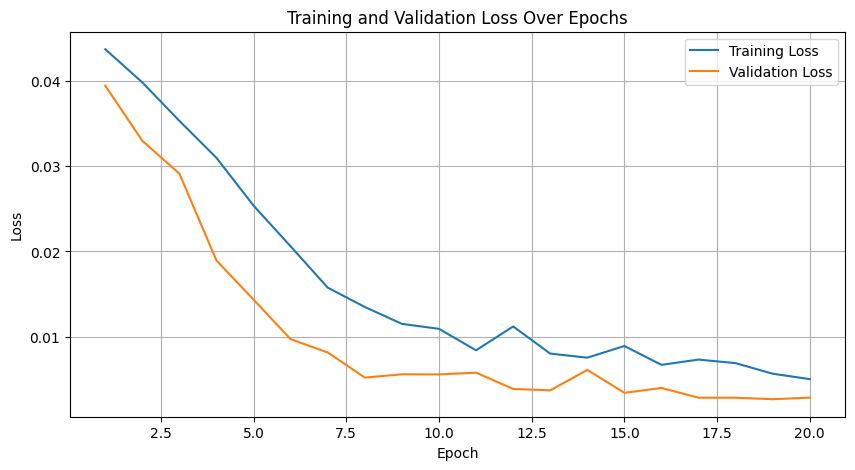

2025-10-09 09:30:05,169 - INFO - Evaluating model performance...


/tmp/ipykernel_32908/34301058.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
[2025-10-09 09:30:34,221] [INFO] [Worker ID: 644295]: Processing video 7500/374...
[2025-10-09 09:31:23,058] [INFO] [Worker ID: 644297]: Processing video 7600/374...
[2025-10-09 09:32:11,764] [INFO] [Worker ID: 644295]: Processing video 7700/374...
[2025-10-09 09:33:01,181] [INFO] [Worker ID: 644297]: Processing video 7800/374...


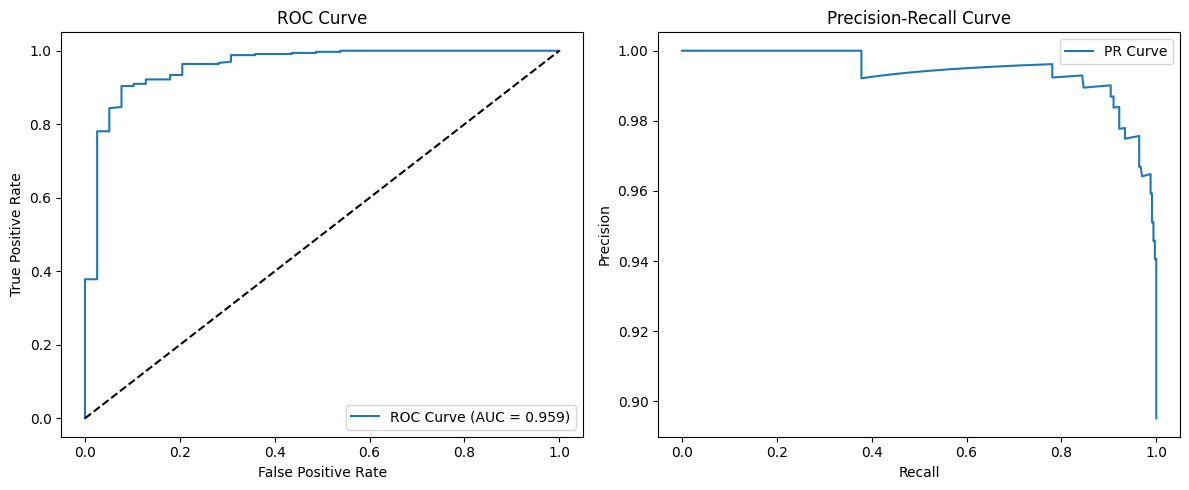

Model Evaluation Results:
Accuracy: 0.9409
AUC-ROC: 0.9587
Equal Error Rate (EER): 0.1026
2025-10-09 09:33:08,062 - INFO - Model saved successfully!


In [7]:
from sklearn.metrics import roc_curve


def evaluate_model(model, val_loader):
    """Comprehensive model evaluation with multiple metrics including EER"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_predictions = []
    all_probabilities = []
    all_targets = []

    with torch.no_grad(), autocast():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            targets = targets.unsqueeze(1)

            outputs = model(data)  # Raw logits

            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()

            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate comprehensive metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    auc_score = roc_auc_score(all_targets, all_probabilities)

    # Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(
        all_targets, all_probabilities
    )

    # Equal Error Rate (EER) calculation
    fpr, tpr, thresh = roc_curve(all_targets, all_probabilities)
    fnr = 1 - tpr
    eer_threshold = thresh[np.nanargmin(np.absolute(fnr - fpr))]
    if np.all(fpr == 0) or np.all(fnr == 0):
        eer = 0.5  # Fallback for degenerate cases
    else:
        eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

    # Plot evaluation metrics
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    axes[0].plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
    axes[0].plot([0, 1], [0, 1], "k--")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("ROC Curve")
    axes[0].legend()

    # Precision-Recall Curve
    axes[1].plot(recall, precision, label=f"PR Curve")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("Precision-Recall Curve")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig("model_evaluation_metrics.png", dpi=300, bbox_inches="tight")
    plt.show()

    print(f"Model Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    print(f"Equal Error Rate (EER): {eer:.4f}")

    return accuracy, auc_score, eer


# Main execution code
if __name__ == "__main__":
    # Explicitly tells CUDA to use the 'spawn' start method
    multiprocessing.set_start_method("spawn", force=True)

    logging.info("Initializing deepfake detection model...")

    # Setup data loaders
    train_loader, val_loader, pos_weight = setup_training()

    # Initialize model
    model = DeepfakeDetector(num_frames=15, backbone="efficientnet_b4")

    logging.info("Starting model training...")
    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, pos_weight, num_epochs=20, patience=5
    )
    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_curves.png")
    plt.show()

    logging.info("Evaluating model performance...")
    accuracy, auc_score, eer = evaluate_model(model, val_loader)

    # Save final model
    torch.save(model.state_dict(), "models/deepfake_detector_model.pth")
    logging.info("Model saved successfully!")